In [1]:
import re
import numpy as np
import pandas as pd
import openpyxl

import geopandas as gpd
from shapely.geometry import Point
from shapely import wkt
import geographiclib
from geographiclib.geodesic import Geodesic
import utm
from shapely.ops import nearest_points

import sys
import os
import requests
from bs4 import BeautifulSoup
from lxml import html
import warnings

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

import urbanpy as up
import contextily as ctx

import io
import json

pd.set_option('display.max_rows',999)
pd.set_option('display.float_format', lambda x: '%.3f' % x)


warnings.filterwarnings("ignore")
#import unicodedata
#import gzip

In [2]:
import plotly.graph_objects as go
import plotly.express as px

In [3]:
import plotly as py

In [4]:
pd.options.display.float_format = '{:,.2f}'.format

idx

In [5]:
idx = pd.IndexSlice

es

In [6]:
es = pd.read_excel('c:/Users/Franco/Python/CAF/files/ES.xlsx' , sheet_name='Biggest Obstacle')

dist

In [7]:
distances = pd.read_excel('C:/Users/Franco/Python/CAF/files/distances.xlsx', index_col = 0)

cwpops

In [380]:
cwpops = pd.read_excel('C:/Users/Franco/Python/CAF/files/cwpops.xlsx', index_col = [0,1])

In [9]:
dic = pd.read_excel('C:/Users/Franco/Python/CAF/files/Diccionario.xlsx',header=1,usecols='B',nrows=10)

dic.columns = ['actividad']

dic['sn'] = 's' + dic['actividad'].str[:2]

dic['sn'] = dic['sn'].str.replace(" ","")

dic['actividad'] = dic['actividad'].str[5:]

dic = dic.rename(columns={'sn':'principal_sector'})

ta

In [272]:
ta = pd.read_excel(r'C:\Users\Franco\Python\CAF\files\tabla ancha 2\tabla_ancha.xlsx',sheet_name='HH')

In [273]:
ta['pais2'] = ta['pais2'].str.title()

In [274]:
ta = ta.rename(columns={'pais2':'Country','Ciudad':'City'}).set_index(['Country','City'])

ta = ta.reset_index().replace({'City':{'Pedro Domingo Murillo (La Paz y el Alto)':'Pedro Domingo Murillo/La Paz y el Alto','Tomas Frías':'Tomas Frías/Potosí','Panama Oeste Arraiján':'Panama Arraiján','Panama Oeste La Chorrera':'Panama La Chorrera','chincha/Chincha Alta':'Chincha/Chincha Alta'}})

ta['City'][ta['Country']=='Colombia']=ta['City'].str.title()

ta.loc[ta['Country']=='Mexico','City'] = ta['City'][ta['Country']=='Mexico'].str.replace('Zona metropolitana de ','').str.replace('Zona metropolitana del ','')

ta = ta.set_index(['Country','City'])

### Acomodar el tema 'Distances' a km

In [13]:
distances['Distance2'] = distances['Distance']

In [14]:
distances.loc[(distances['Distance'].str.contains(' ft| m')),'Distance2'] = '0 km'

In [15]:
distances['distance_km'] = distances['Distance2'].apply(lambda x: x.replace(' km',''))

In [16]:
distances['distance_km'] = distances['distance_km'].astype('float')

In [17]:
del distances['Distance2']

### Base cutoff

In [18]:
def get_wages_from_cutoff(city_index, cutoff):
    city_wage = cwpops.drop_duplicates('index1').loc[city_index]['estimated_citywage']
    distan = distances[(distances['Country'] == city_index[0])
                            &(distances['City A'] == city_index[1])
                            &(distances['parsed_duration'] <= cutoff)].drop_duplicates('City B')

    nearby_cities = [(x,y) for x,y in distan[['Country','City B']].values.tolist()]
    if len(nearby_cities) == 0:
        return city_wage
    else:
        nearby_wages = cwpops.loc[nearby_cities]['estimated_citywage'].sum()
        return nearby_wages + city_wage

In [19]:
def get_countryshare_from_cutoff(city_index, cutoff, share_out = True):
    nearwages = get_wages_from_cutoff(city_index, cutoff = cutoff)
    country_wages = cwpops.groupby('Country')['estimated_citywage'].sum().loc[city_index[0]]
    share = nearwages/country_wages
    if share_out == True:
        return share
    else:
        return nearwages

In [20]:
shares_cutoff = pd.DataFrame(index = cwpops.index)

In [21]:
shares_cutoff['index1'] = shares_cutoff.index
for i in range(10):
    shares_cutoff['cutoff_' + str(i)] = shares_cutoff['index1'].apply(lambda x: get_countryshare_from_cutoff(x , cutoff = i))

In [22]:
shares_cutoff = pd.concat([shares_cutoff, shares_cutoff.mean().to_frame(('Promedios','Promedios')).T])

### Base Congestion

In [23]:
distances['dit_elementos'] = distances['Duration in traffic'].apply(lambda x: len(re.split('day|hour|mins|seconds',x)))

In [24]:
distances['duration_traffic'] = np.nan

for i, row in distances.iterrows():
    if 'second' in row['Duration in traffic']:
        distances.loc[i,'duration_traffic']  = float(0)
    elif 'mins' in row['Duration in traffic'] and 'hour' not in row['Duration in traffic']:
        if len(row['Duration in traffic'].replace(' mins','')) > 1:
            distances.loc[i,'duration_traffic']  = float('0.'+row['Duration in traffic'].replace(' mins',''))*100/60
        else:
            distances.loc[i,'duration_traffic']  = float('0.0'+row['Duration in traffic'].replace(' mins',''))*100/60
    elif 'hour' in row['Duration in traffic'] and 'day' not in row['Duration in traffic']:
        if len(row['Duration in traffic'].split(' hour ')[1].replace(' mins','')) > 1:
            distances.loc[i,'duration_traffic'] = float(row['Duration in traffic'].split(' hour ')[0])+float('.'+row['Duration in traffic'].split(' hour ')[1].replace(' mins',''))*100/60
        else:
            distances.loc[i,'duration_traffic'] = float(row['Duration in traffic'].split(' hour ')[0])+float('.0'+row['Duration in traffic'].split(' hour ')[1].replace(' mins',''))*100/60
    elif 'day' in row['Duration in traffic']:
        a = re.split(' day | hour | mins',row['Duration in traffic'])
        if len(a[2]) > 1:
            distances.loc[i,'duration_traffic']  = float(a[0])*24+float(a[1])+float('.'+a[2])*100/60
        else:
            distances.loc[i,'duration_traffic']  = float(a[0])*24+float(a[1])+float('.0'+a[2])*100/60

### Nueva base Garganta: eph

In [275]:
eph = pd.read_excel('c:/Users/Franco/Python/CAF/files/eph/{}'.format(os.listdir("c:/Users/Franco/Python/CAF/files/eph")[2]),header=[4,5]).dropna(how='all').dropna(axis=1,how='all')

In [276]:
eph = eph.drop(columns=eph.columns[:3].tolist())

In [277]:
eph[('Country','Country')] = np.nan

In [278]:
eph = eph.rename(columns={'Unnamed: 3_level_1':'City'},level=1).rename(columns={'Unnamed: 3_level_0':'City'},level=0)

In [279]:
eph = eph.rename(columns={'Unnamed: 4_level_0':'Salario Horario (PPP 2011)'},level=0)

In [280]:
eph.loc[(eph[('City','City')].str.contains('total ciudades')),('Country','Country')] = eph.loc[(eph[('City','City')].str.contains('total ciudades')),('City','City')].apply(lambda x: x.split(' ',1)[0])

In [281]:
eph[('Country','Country')] = eph[('Country','Country')].ffill()

In [282]:
eph.loc[eph[('Country','Country')]=='Mexico',('City','City')] = eph.loc[eph[('Country','Country')] == 'Mexico'][('City','City')].str.replace('Zona metropolitana de ','').str.replace('Zona metropolitana del ','')

In [283]:
eph[('City','City')][eph[('Country','Country')]=='Colombia']=eph[('City','City')].str.title()

In [284]:
eph = eph.replace({('City','City'):{'Pedro Domingo Murillo (La Paz y el Alto)':'Pedro Domingo Murillo/La Paz y el Alto','Tomas Frías':'Tomas Frías/Potosí','Panama Oeste Arraiján':'Panama Arraiján','Panama Oeste La Chorrera':'Panama La Chorrera','chincha/Chincha Alta':'Chincha/Chincha Alta'}})

In [285]:
#eph.loc[:,[('Country','Country'),('City','City')]].droplevel(level=0,axis=1)
#eph[[('Country','Country'),('City','City')]] = 
#eph[[('Country','Country'),('City','City')]].droplevel(level=1,axis=1)
eph['pais'] = eph[('Country','Country')].to_frame().droplevel(level=0,axis=1)
eph['ciudad'] = eph[('City','City')].to_frame().droplevel(level=0,axis=1)

In [286]:
eph = eph.drop(columns=[('Country','Country'),('City','City')]).rename(columns={'pais':'Country','ciudad':'City'}).set_index(['Country','City'])

In [287]:
mylist = ['Gran Area Metropolitana',
'Montevideo',
'Canelones',
'Ciudad Del Plata']

In [288]:
eph.loc[eph.index.get_level_values(1).str.contains('Área Metropolitana',regex=False),:].reset_index()['City'].tolist()

['Central  (incluye Gran Área Metropolitana)',
 'Montevideo (Área Metropolitana)',
 'Canelones Área Metropolitana (gran parte de Canelones y Ciudad de la Costa, y otros)',
 'Ciudad del Plata (Área Metropolitana)']

In [289]:
mydict = dict(zip(eph.loc[eph.index.get_level_values(1).str.contains('Área Metropolitana',regex=False),:].reset_index()['City'].tolist(),mylist))

In [290]:
eph = eph.reset_index().replace({eph.reset_index().columns[1]:mydict}).set_index(['Country','City'])

Tema suma de asalariados

In [291]:
[eph[eph.columns[20]],eph[eph.columns[21]]] = [(eph.iloc[:,20] * eph.iloc[:,19] / (eph.iloc[:,20] + eph.iloc[:,21])), (eph.iloc[:,21] * eph.iloc[:,19] / (eph.iloc[:,20] + eph.iloc[:,21]))]

### Latlongs

In [42]:
latlongs = distances[['Country','City A','Point A']].rename(columns = {'City A':'City'}).set_index(['Country','City']).drop_duplicates().rename(columns = {'Point A':'latlong'}).dropna()
latlongs[['lat','long']] = latlongs['latlong'].apply(lambda x: pd.Series(x.split(','))).astype(float)
latlongs = latlongs.drop('latlong', axis = 1)

In [43]:
latlongs = latlongs.join(cwpops.loc[:,'pops'],how='inner').join(eph.loc[:,('Salario Horario (PPP 2011)','Salario Horario (PPP 2011)')],how='inner').rename(columns={'pops':'población estimada',('Salario Horario (PPP 2011)','Salario Horario (PPP 2011)'):'Salario promedio (usd/hora)'})

In [44]:
latlongs = gpd.GeoDataFrame(latlongs, geometry=gpd.points_from_xy(latlongs.long, latlongs.lat))
latlongs = latlongs.drop(columns=['lat','long'])

In [45]:
latlongs = latlongs.dropna().astype(dtype={'población estimada':'int','Salario promedio (usd/hora)':'float'})

In [46]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

## Definición de cantidad de ciudades disponibles

In [47]:
merge = cwpops.loc[:,'pops'].to_frame().join(eph.loc[:,[('Salario Horario (PPP 2011)','Salario Horario (PPP 2011)'),('Tasa de Desempleo','Total'),('% población con secundario completo', 'Total')]].droplevel(1,axis=1),how='inner').join(ta.iloc[:,33:36],how='inner').join(shares_cutoff.iloc[:,[1,-1]],how='inner')

In [48]:
merge['pops'] = merge['pops'] / 1000000

In [49]:
merge = merge.rename(columns={'pops':'Población estimada (millones)'})

In [50]:
merge

Población estimada (millones)  \
Country   City                                                                    
Argentina Bahia Blanca-Cerri                                               0.31   
          Ciudad de Buenos Aires                                           3.08   
          Comodoro Rivadavia-Rada Tilly                                    0.24   
          Concordia                                                        0.17   
          Corrientes                                                       0.35   
          Formosa                                                          0.22   
          Gran Catamarca                                                   0.16   
          Gran Cordoba                                                     1.43   
          Gran La Plata                                                    0.20   
          Gran Mendoza                                                     0.11   
          Gran Parana                                                      0.25   
          Gran Resistencia                                                 0.29   
          Gran Rosario                                                     1.20   
          Gran San Juan                                                    0.47   
          Gran Santa Fe                                                    0.41   
          Gran Tucuman-Tafi Viejo                                          1.45   
          Jujuy-Palpala                                                    0.27   
          La Rioja                                                         0.18   
          Mar del Plata-Batan                                              0.66   
          Neuquen-Plottier                                                 0.34   
          Partidos del GBA                                                15.41   
          Posadas                                                          0.28   
          Rawson-Trelew                                                    0.03   
          Rio Cuarto                                                       0.19   
          Rio Gallegos                                                     0.10   
          Salta                                                            0.53   
          San Luis-El Chorrillo                                            0.17   
          San Nicolas-Villa Constitucion                                   0.16   
          Santa Rosa-Toay                                                  0.10   
          Santiago del Estero-La Banda                                     0.91   
          Ushuaia-Rio Grande                                               0.06   
          Viedma-Carmen de Patagones                                       0.08   
Bolivia   Andrés Ibañez/Santa Cruz de la Sierra                            3.15   
          Cercado/Cochabamba                                               1.92   
          Cercado/Oruro                                                    0.26   
          Cercado/Tarija                                                   0.25   
          Cercado/Trinidad                                                 0.12   
          Nicolas Suarez/Cobija                                            0.06   
          Obispo Santisteban/Montero                                       0.11   
          Oropeza                                                          0.01   
          Pedro Domingo Murillo/La Paz y el Alto                           2.87   
          Quillacollo                                                      0.16   
          Tomas Frías/Potosí                                               0.21   
          Vaca Diez                                                        0.10   
Brasil    Aracaju                                                          0.62   
          Belem                                                            0.14   
          Belo Horizonte                                          

In [50]:
promedios = merge.groupby('Country').mean()

In [51]:
promedios['City'] = 'Promedio'

In [52]:
promedios = promedios.reset_index().set_index(['Country','City'])

In [53]:
merge = merge.append(promedios)

In [54]:
promedio = merge.mean().to_frame().T

In [55]:
[promedio['Country'],promedio['City']] = ['Promedio','Promedio']

In [56]:
promedio = promedio.set_index(['Country','City'])

In [57]:
merge = merge.append(promedio)

In [58]:
merge = merge.sort_index().join(promedios.iloc[:,4:7].droplevel(1),rsuffix=' promedio')

In [59]:
merge['Ratio Agro'], merge['Ratio Ind Baja'], merge['Ratio Resto Ind'] = [merge['Agro']/merge['Agro promedio'],merge['Baja Tec']/merge['Baja Tec promedio'],merge['Resto Ind']/merge['Resto Ind promedio']]

In [60]:
#merge = merge.iloc[:,np.r_[0:4,7:9,-3:-0]]

### Ciudades de referencia

In [61]:
ref_com = [
'Manizales'
,'Pereira'
,'Medellin'
,'Armenia'
,'Villavicencio'
,'Monteria'
,'Bucaramanga'
,'Ibague'
,'Tunja'
]

In [62]:
ref_com = ref_com + ['promedio Colombia','promedio Latam','Florianopolis','Bahia Blanca-Cerri','San Luis Potosí']

In [63]:
ref_com

['Manizales',
 'Pereira',
 'Medellin',
 'Armenia',
 'Villavicencio',
 'Monteria',
 'Bucaramanga',
 'Ibague',
 'Tunja',
 'promedio Colombia',
 'promedio Latam',
 'Florianopolis',
 'Bahia Blanca-Cerri',
 'San Luis Potosí']

In [91]:
merge.loc['Colombia'].mean()

Población estimada (millones)          1.050
Salario Horario (PPP 2011)             3.714
Tasa de Desempleo                     10.546
% población con secundario completo   40.329
cutoff_0                               0.043
cutoff_9                               0.424
Ratio Agro                             1.000
Ratio Ind Baja                         1.000
Ratio Resto Ind                        1.000
dtype: float64

In [64]:
rc = merge.loc[idx['Colombia',ref_com],:].sort_values(merge.columns[0],ascending=False)

In [65]:
rc = rc.append(merge.loc[idx[:,['Bahia Blanca-Cerri','Florianopolis','San Luis Potosí']],:])

In [66]:
rc = rc.rename(columns={'cutoff_0':'Masa Salarial como proporción del país','cutoff_9':'Proporción de la masa salarial del país a la que se accede en < 9 hs'})

In [78]:
print(BeautifulSoup(rc.to_html(), 'html.parser'))

<table border="1" class="dataframe">
<thead>
<tr style="text-align: right;">
<th></th>
<th></th>
<th>Población estimada (millones)</th>
<th>Salario Horario (PPP 2011)</th>
<th>Tasa de Desempleo</th>
<th>% población con secundario completo</th>
<th>Masa Salarial como proporción del país</th>
<th>Proporción de la masa salarial del país a la que se accede en &lt; 9 hs</th>
<th>Ratio Agro</th>
<th>Ratio Ind Baja</th>
<th>Ratio Resto Ind</th>
</tr>
<tr>
<th>Country</th>
<th>City</th>
<th></th>
<th></th>
<th></th>
<th></th>
<th></th>
<th></th>
<th></th>
<th></th>
<th></th>
</tr>
</thead>
<tbody>
<tr>
<th rowspan="9" valign="top">Colombia</th>
<th>Armenia</th>
<td>2.960</td>
<td>3.393</td>
<td>7.870</td>
<td>36.443</td>
<td>0.108</td>
<td>0.784</td>
<td>1.363</td>
<td>0.724</td>
<td>0.826</td>
</tr>
<tr>
<th>Medellin</th>
<td>2.427</td>
<td>3.547</td>
<td>13.896</td>
<td>39.631</td>
<td>0.107</td>
<td>0.782</td>
<td>0.564</td>
<td>1.912</td>
<td>1.794</td>
</tr>
<tr>
<th>Pereira</th>
<td>0.59

In [94]:
ref_col = [
'Manizales'
,'Pereira'
,'Medellin'
,'Armenia'
,'Villavicencio']

In [95]:
ref_cer  = [
'Bahia Blanca-Cerri'
,'Florianopolis'
,'San Luis Potosí'
]

In [96]:
ref = ref_col + ref_cer

In [97]:
ref2 = ref + ['promedio Latam','promedio Colombia','Bahía Blanca','San Luis']

In [93]:
#eph.loc[eph.index.get_level_values(level=1).str.contains('(total ciudades)',regex=False)].iloc[:,19:24]
#eph.loc['Colombia']

Salario Horario (PPP 2011)  \
                               Salario Horario (PPP 2011)   
City                                                        
Colombia 2018 (Total Ciudades)                       4.28   
Medellin                                             3.55   
Barranquilla                                         3.54   
Bogota                                               5.56   
Cartagena                                            4.08   
Tunja                                                4.33   
Manizales                                            3.19   
Florencia                                            3.12   
Popayan                                              3.33   
Valledupar                                           3.27   
Monteria                                             4.07   
Quibdo                                               4.56   
Neiva                                                3.04   
Riohacha                                             3.69   
Santa Marta                                          3.84   
Villavicencio                                        3.61   
Pasto                                                3.54   
Cucuta                                               4.06   
Armenia                                              3.39   
Pereira                                              3.29   
Bucaramanga                                          3.04   
Sincelejo                                            4.05   
Ibague                                               3.16   
Cali                                                 4.11   

                               % Asalariados Informales                   \
                                                  Total Mujeres  Hombres   
City                                                                       
Colombia 2018 (Total Ciudades)                    29.60    32.54   27.02   
Medellin                                          27.66    28.44   27.21   
Barranquilla                                      32.14    38.60   27.08   
Bogota                                            23.45    24.82   22.16   
Cartagena                                         29.49    32.76   26.52   
Tunja                                             31.79    36.93   27.55   
Manizales                                         27.92    34.18   22.31   
Florencia                                         32.61    36.13   29.42   
Popayan                                           50.62    57.14   45.40   
Valledupar                                        46.17    46.88   45.60   
Monteria                                          29.83    32.17   28.01   
Quibdo                                            25.19    26.98   23.71   
Neiva                                             48.50    51.10   46.06   
Riohacha                                          28.76    35.63   21.68   
Santa Marta                                       46.92    49.47   44.42   
Villavicencio                                     35.29    35.76   34.95   
Pasto                                             39.20    44.56   33.85   
Cucuta                                            36.36    34.20   38.66   
Armenia                                           31.33    36.00   25.30   
Pereira                                           31.84    40.23   24.20   
Bucaramanga                                       43.28    46.05   40.44   
Sincelejo                                         34.34    39.19   30.02   
Ibague                                            30.50    37.57   23.93   
Cali                                              39.65    44.51   35.69   

                               Tasa de Actividad                   \
                                           Total Mujeres  Hombres   
City                                                                
Colombia 2018 (Total Ciudades)             68.57    59.44   78.76   
Medellin                                   68.12    56

Gráfico de Salarios y poblaciones

In [105]:
plot1 = rc.iloc[:,:2].droplevel(0)

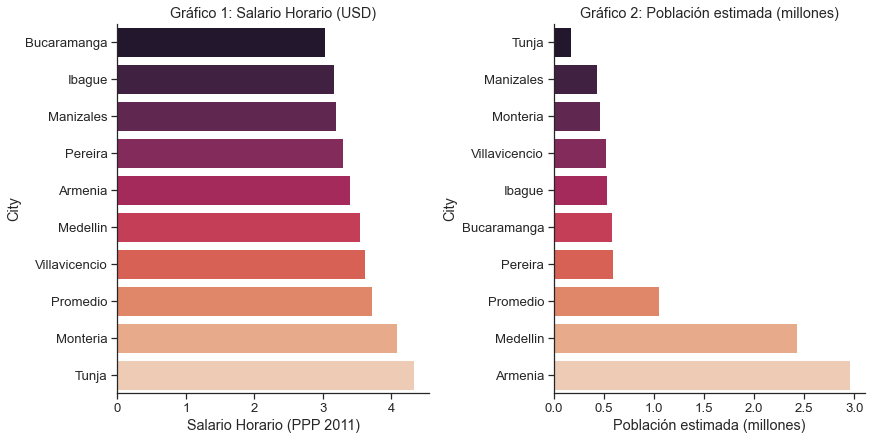

In [108]:
f, axes = plt.subplots(1, 2,figsize=(12,6) ,constrained_layout=True)

sns.barplot(x='Salario Horario (PPP 2011)', y=plot1.sort_values('Salario Horario (PPP 2011)').index, data=plot1.sort_values('Salario Horario (PPP 2011)'),palette='rocket' , orient='h' , ax=axes[0]).set_title('Gráfico 1: Salario Horario (USD)')
sns.barplot(x='Población estimada (millones)', y=plot1.sort_values('Población estimada (millones)').index, data=plot1.sort_values('Población estimada (millones)'),palette='rocket' , orient='h'  ,ax=axes[1]).set_title('Gráfico 2: Población estimada (millones)')

sns.set(font_scale=1.2)
sns.set_style("ticks")
sns.despine()

plt.ticklabel_format(style='plain', axis='x')
#plt.tight_layout()

#axes[1].get_xaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.savefig("C:/Users/Franco/Python/CAF/Entregables/Informes/manizales 2/informe/images/wyp.png",bbox_inches='tight')

Comparación con Monteria

In [84]:
gen1 = rc.iloc[np.r_[2,-3,-2],np.r_[2,3]].droplevel(0)

In [85]:
gen2 = rc.iloc[np.r_[2,-3,-2],np.r_[-3,-2,-1]].droplevel(0)

In [90]:
rc

Población estimada (millones)  \
Country   City                                                
Colombia  Armenia                                     2.960   
          Medellin                                    2.427   
          Pereira                                     0.591   
          Bucaramanga                                 0.581   
          Ibague                                      0.530   
          Villavicencio                               0.528   
          Monteria                                    0.460   
          Manizales                                   0.434   
          Tunja                                       0.173   
Argentina Bahia Blanca-Cerri                          0.310   
Brasil    Florianopolis                               0.478   
Mexico    San Luis Potosí                             0.824   

                              Salario Horario (PPP 2011)  Tasa de Desempleo  \
Country   City                                                                
Colombia  Armenia                                  3.393              7.870   
          Medellin                                 3.547             13.896   
          Pereira                                  3.289              7.636   
          Bucaramanga                              3.036              9.818   
          Ibague                                   3.164             12.093   
          Villavicencio                            3.608              8.242   
          Monteria                                 4.075             10.995   
          Manizales                                3.194              6.761   
          Tunja                                    4.329             11.657   
Argentina Bahia Blanca-Cerri                       6.497              9.010   
Brasil    Florianopolis                            5.935              6.505   
Mexico    San Luis Potosí                          4.573              3.152   

                              % población con secundario completo  \
Country   City                                                      
Colombia  Armenia                                          36.443   
          Medellin                                         39.631   
          Pereira                                          37.533   
          Bucaramanga                                      35.884   
          Ibague                                           38.096   
          Villavicencio                                    40.838   
          Monteria                                         42.433   
          Manizales                                        39.311   
          Tunja                                            44.022   
Argentina Bahia Blanca-Cerri                               49.041   
Brasil    Florianopolis                                    43.246   
Mexico    San Luis Potosí                                  32.462   

                              Masa Salarial como proporción del país  \
Country   City                                                         
Colombia  Armenia                                              0.108   
          Medellin                                             0.107   
          Pereira                                              0.022   
          Bucaramanga                                          0.025   
          Ibague                                               0.018   
          Villavicencio                                        0.019   
          Monteria                                             0.014   
          Manizales                                            0.017   
          Tunja                                                0.007   
Argentina Bahia Blanca-Cerri                                   0.011   
Brasil    Florianopolis                                        0.009   
Mexico    San Luis Potosí                                      0.011   

                              Proporción de la masa salarial del

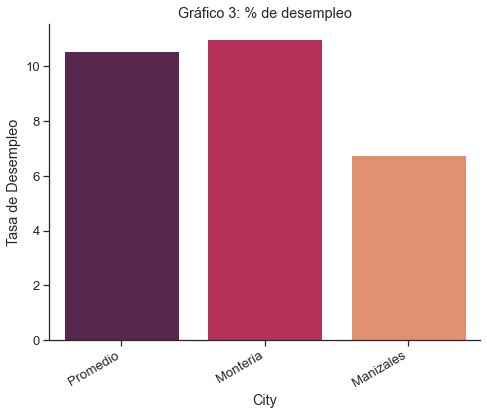

In [254]:
fig, ax = plt.subplots(figsize=(7,6))

sns.barplot(x=gen1.index, y='Tasa de Desempleo', data=gen1, palette='rocket').set_title('Gráfico 3: % de desempleo')
#sns.barplot(x=gen1.index, y='% población con secundario completo', data=gen1, ax=ax[1], palette='rocket')#.set_title('Gráfico 7: % Informalidad (Mujeres)')

fig.autofmt_xdate()
sns.set(font_scale=1.2)
sns.set_style("ticks")
sns.despine()

plt.savefig("C:/Users/Franco/Python/CAF/Entregables/Informes/manizales 2/informe/images/monteria_desempleo.png",bbox_inches='tight')
plt.tight_layout()

In [102]:
gen3 = rc.loc[idx[:,['Monteria','Manizales']],['Ratio Agro','Ratio Ind Baja','Ratio Resto Ind']].stack().to_frame().reset_index().set_index('City').rename(columns={'level_2':'Actividad',0:'valor'})

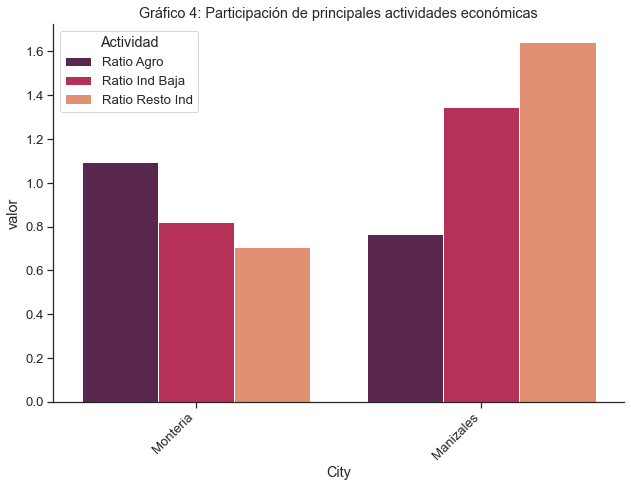

In [107]:
fig, ax = plt.subplots(figsize=(9,7)) #,constrained_layout=True

g = sns.barplot(x=gen3.index, y='valor', hue='Actividad', data=gen3 , palette='rocket' , linewidth=1)

g.set_title('Gráfico 4: Participación de principales actividades económicas')
g.set_xticklabels(gen3.index.unique().tolist() , rotation=45 , ha='right')

sns.set(font_scale=1.2)
sns.set_style("ticks")
sns.despine()
plt.savefig("C:/Users/Franco/Python/CAF/Entregables/Informes/manizales 2/informe/images/monteria_ta.png",bbox_inches='tight')
plt.tight_layout()

In [113]:
dist = eph.loc[rc.index.tolist()+[('Colombia','Colombia 2018 (Total Ciudades)')],eph.columns[19:24]]

In [114]:
dist.columns = dist.columns.droplevel(0)

In [115]:
dist.index = dist.index.droplevel(0)

In [116]:
a = dist.loc[['Monteria','Manizales','Colombia 2018 (Total Ciudades)']].drop(columns='Asalariado  (total)')

In [117]:
a

Asalariado (público)  Asalariado (privado)  \
City                                                                         
Monteria                                       7.579                53.655   
Manizales                                      3.924                32.617   
Colombia 2018 (Total Ciudades)                 4.551                47.813   

                                Patrón o Cuentapropista  Sin salario  
City                                                                  
Monteria                                         37.064        1.702  
Manizales                                        59.949        3.509  
Colombia 2018 (Total Ciudades)                   45.334        2.302

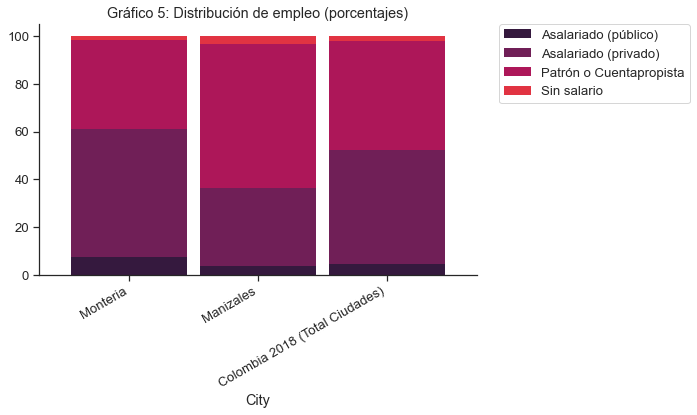

In [255]:
sns.set_palette('rocket')

fig, ax = plt.subplots(1, 1,figsize=(10,6))

a.plot(kind='bar', stacked=True , ax=ax , color=sns.color_palette() , width=0.9 , linewidth=0.001).set_title('Gráfico 5: Distribución de empleo (porcentajes)')

fig.autofmt_xdate()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig("C:/Users/Franco/Python/CAF/Entregables/Informes/manizales 2/informe/images/monteria_dist.png",bbox_inches='tight')
plt.tight_layout()

Brecha salarial contra el promedio del pais

In [79]:
gcol = latlongs.loc['Colombia'].join(eph.loc['Colombia',('Salario Horario (PPP 2011)', 'Salario Horario (PPP 2011)')]).drop(columns=[latlongs.columns[0],latlongs.columns[1]])

In [80]:
gcol = gcol.rename(columns={gcol.columns[1]:'Salario Hora (USD)'})

In [81]:
gcol['brecha salarial (promedio país)'] = gcol['Salario Hora (USD)'] / eph.loc[('Colombia','Colombia 2018 (Total Ciudades)')][0]

In [82]:
#gcol = gcol.drop(index=['Ibague'])

In [289]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [310]:
#gcol.drop(index=['Bogota']).sort_values('brecha salarial (Bogotá)',ascending=False) #iloc[:10,-1].to_frame()

población estimada  Salario promedio (usd/hora)  \
City                                                             
Quibdo                     115517                        4.557   
Tunja                      172548                        4.329   
Cali                      2228000                        4.105   
Cartagena                  914552                        4.080   
Monteria                   460223                        4.075   
Cucuta                     750000                        4.064   
Sincelejo                  277773                        4.050   
Santa Marta                515556                        3.839   
Riohacha                   244836                        3.692   
Villavicencio              527668                        3.608   
Medellin                  2427000                        3.547   
Barranquilla              1274250                        3.537   
Pasto                      460638                        3.536   
Armenia                   2959694                        3.393   
Popayan                    300837                        3.334   
Pereira                    590554                        3.289   
Valledupar                 490075                        3.272   
Manizales                  434403                        3.194   
Florencia                  168346                        3.124   
Neiva                      316033                        3.040   
Bucaramanga                581130                        3.036   

                                 geometry  brecha salarial (Bogotá)  
City                                                                 
Quibdo          POINT (-76.65405 5.68457)                     0.819  
Tunja           POINT (-73.36200 5.54100)                     0.778  
Cali            POINT (-76.52300 3.43800)                     0.738  
Cartagena      POINT (-75.49800 10.37700)                     0.734  
Monteria        POINT (-75.88600 8.75000)                     0.733  
Cucuta          POINT (-72.50600 7.89000)                     0.731  
Sincelejo       POINT (-75.39800 9.30200)                     0.728  
Santa Marta    POINT (-74.20200 11.23200)                     0.690  
Riohacha       POINT (-72.91200 11.54300)                     0.664  
Villavicencio   POINT (-73.63100 4.13800)                     0.649  
Medellin        POINT (-75.58500 6.25000)                     0.638  
Barranquilla   POINT (-74.80300 10.95200)                     0.636  
Pasto           POINT (-77.27900 1.21200)                     0.636  
Armenia         POINT (-75.69100 4.53500)                     0.610  
Popayan         POINT (-76.60200 2.46000)                     0.600  
Pereira         POINT (-75.70500 4.81800)                     0.591  
Valledupar     POINT (-73.26100 10.46400)                     0.588  
Manizales       POINT (-75.50700 5.06200)                     0.574  
Florencia       POINT (-75.60812 1.75542)                     0.562  
Neiva           POINT (-75.28500 2.94100)                     0.547  
Bucaramanga     POINT (-73.12900 7.10100)                     0.546

In [83]:
gcol

geometry  Salario Hora (USD)  \
City                                                            
Armenia         POINT (-75.69100 4.53500)               3.393   
Barranquilla   POINT (-74.80300 10.95200)               3.537   
Bogota          POINT (-74.12900 4.64400)               5.561   
Bucaramanga     POINT (-73.12900 7.10100)               3.036   
Cali            POINT (-76.52300 3.43800)               4.105   
Cartagena      POINT (-75.49800 10.37700)               4.080   
Cucuta          POINT (-72.50600 7.89000)               4.064   
Florencia       POINT (-75.60812 1.75542)               3.124   
Ibague          POINT (-75.21100 4.44200)               3.164   
Manizales       POINT (-75.50700 5.06200)               3.194   
Medellin        POINT (-75.58500 6.25000)               3.547   
Monteria        POINT (-75.88600 8.75000)               4.075   
Neiva           POINT (-75.28500 2.94100)               3.040   
Pasto           POINT (-77.27900 1.21200)               3.536   
Pereira         POINT (-75.70500 4.81800)               3.289   
Popayan         POINT (-76.60200 2.46000)               3.334   
Quibdo          POINT (-76.65405 5.68457)               4.557   
Riohacha       POINT (-72.91200 11.54300)               3.692   
Santa Marta    POINT (-74.20200 11.23200)               3.839   
Sincelejo       POINT (-75.39800 9.30200)               4.050   
Tunja           POINT (-73.36200 5.54100)               4.329   
Valledupar     POINT (-73.26100 10.46400)               3.272   
Villavicencio   POINT (-73.63100 4.13800)               3.608   

               brecha salarial (promedio país)  
City                                            
Armenia                                  0.793  
Barranquilla                             0.827  
Bogota                                   1.300  
Bucaramanga                              0.710  
Cali                                     0.959  
Cartagena                                0.954  
Cucuta                                   0.950  
Florencia                                0.730  
Ibague                                   0.740  
Manizales                                0.746  
Medellin                                 0.829  
Monteria                                 0.952  
Neiva                                    0.710  
Pasto                                    0.826  
Pereira                                  0.769  
Popayan                                  0.779  
Quibdo                                   1.065  
Riohacha                                 0.863  
Santa Marta                              0.897  
Sincelejo                                0.946  
Tunja                                    1.012  
Valledupar                               0.765  
Villavicencio                            0.843

<Figure size 432x288 with 0 Axes>

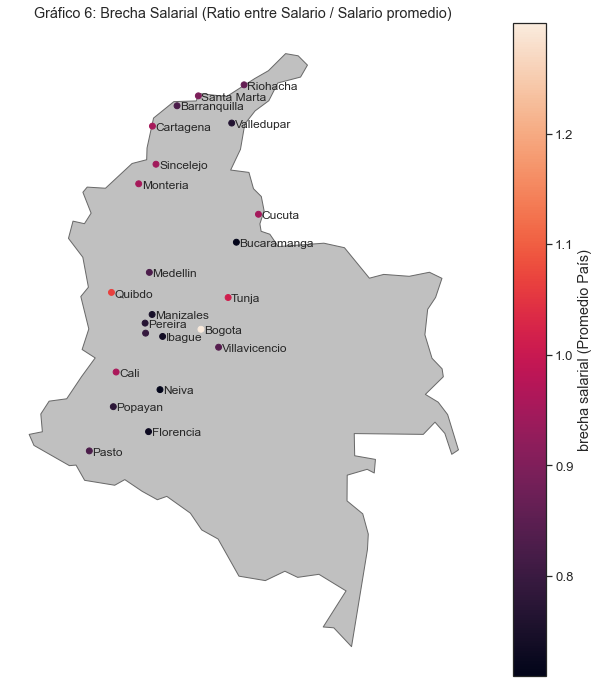

In [309]:
fig = plt.figure()
mpl.rcParams['figure.facecolor'] = 'white'

ax = world[world['name'].isin(['Colombia'])].plot(color='silver', figsize = (12,12), edgecolor='dimgrey') #,'Ecuador','Venezuela','Panama'
ax.axis('off')

bg_color = 'lightgrey'
ax.patch.set_facecolor(bg_color)

for x, y, label in zip(gcol.drop(index='Armenia').geometry.x, gcol.drop(index='Armenia').geometry.y, gcol.drop(index='Armenia').index):
    ax.annotate(label, xy=(x, y), xytext=(3, -4), textcoords="offset points" ,size=12)

gcol.plot(column='brecha salarial (promedio país)' , ax = ax, legend = True,  legend_kwds={'label':'brecha salarial (Promedio País)'}, markersize = 35 , cmap='rocket').set_title('Gráfico 6: Brecha Salarial (Ratio entre Salario / Salario promedio)')
plt.savefig("C:/Users/Franco/Python/CAF/Entregables/Informes/manizales 2/informe/images/brecha_promedio.png" ,bbox_inches='tight')

## Disponibilidad de indicadores

### Con Ext

In [410]:
mlab = pd.read_csv('C:/Users/Franco/Python/CAF/files/mlab-cities.csv')

In [417]:
mylist = ta.reset_index().loc[:,'Country'].unique().tolist()

In [418]:
mylist

['Argentina',
 'Bolivia',
 'Brasil',
 'Chile',
 'Colombia',
 'Costa Rica',
 'Ecuador',
 'Mexico',
 'Panama',
 'Peru',
 'Paraguay',
 'Uruguay']

In [419]:
mlab = mlab.replace({'Country':{'Brazil':'Brasil'}})
mlab_latam = mlab.loc[mlab['Country'].isin(mylist),:]

In [420]:
mlab_latam

(10774, 6)

Duplicados de ciudades con mismo nombre pero sin acento

In [421]:
mylist2 = [('Brasil', 'Belem'),
 ('Brasil', 'Brasilia'),
 ('Brasil', 'Florianopolis'),
 ('Brasil', 'Macapa'),
 ('Colombia', 'Bogota'),
 ('Colombia', 'Medellin'),
 ('Colombia', 'Monteria')]

In [422]:
mlab_latam = mlab_latam.set_index(['Country','City'])

In [423]:
mlab_latam = mlab_latam.loc[~mlab_latam.index.isin(mylist2)]

In [424]:
mlab_latam = mlab_latam.reset_index()

In [425]:
mlab_latam['Ciudad'] = mlab_latam['City']

In [426]:
mlab_latam = mlab_latam.set_index(['Country','City'])

In [106]:
mylist.remove('Mexico')

In [107]:
mylist.remove('Paraguay')

In [108]:
mlab_latam1 = mlab_latam.loc[idx[mylist,:],:]

In [109]:
mlab_latam1['Ciudad'] = mlab_latam1['Ciudad'].str.lower().apply(lambda x: x.replace('á','a').replace('é','e').replace('í','i').replace('ó','o').replace('ú','u')).str.title()

In [110]:
mlab_latam.update(mlab_latam1)

In [111]:
mlab_latam = mlab_latam.reset_index().drop(columns='City').rename(columns={'Ciudad':'City'}).set_index(['Country','City'])

In [112]:
mydict = {'Bahia Blanca':'Bahia Blanca-Cerri'
,'Buenos Aires':'Ciudad de Buenos Aires'
,'Mar Del Plata':'Mar del Plata-Batan'
,'Neuquen':'Neuquen-Plottier'
,'Catamarca':'Gran Catamarca'
,'Cordoba':'Gran Cordoba'
,'La Plata':'Gran La Plata'
,'Mendoza':'Gran Mendoza'
,'Parana':'Gran Parana'
,'Resistencia':'Gran Resistencia'
,'Rosario':'Gran Rosario'
,'San Juan':'Gran San Juan'
,'Santa Fe':'Gran Santa Fe'
,'San Miguel De Tucuman':'Gran Tucuman-Tafi Viejo'
,'Rio De Janeiro':'Rio de Janeiro'
,'Santiago':'Región Metropolitana de Santiago'
,'Rawson':'Rawson-Trelew'
,'La Paz':'Pedro Domingo Murillo/La Paz y el Alto'
,'Santa Cruz':'Andrés Ibañez/Santa Cruz de la Sierra'
,'Cochabamba':'Cercado/Cochabamba'
,'Oruro':'Cercado/Oruro'
,'Potosi':'Tomas Frías/Potosí'
,'Goiânia':'Goiania'
,'Ciudad Juárez':'Juárez'
,'Lima':'Callao y Lima'
,'Puebla':'Puebla-Tlaxcala'
,'Mexico':'Valle de México'
,'Queretaro':'Querétaro'
,'San Luis':'San Luis Potosí'
,'Apizaco':'Tlaxcala-Apizaco'
,'Arequipa':'Arequipa -area metropolitana'
,'Cusco':'Cuzco'
,'Chihuahua City':'Chihuahua'
,'Acapulco de Juárez':'Acapulco'}

In [113]:
mlab_latam =  mlab_latam.reset_index().replace({'City':mydict}).set_index(['Country','City'])

In [114]:
mlab_clean = mlab_latam.join(merge.iloc[:,0],how='inner')

Medias

In [751]:
mlab_medias = mlab_clean.mean().to_frame().T.append(mlab_clean.loc['Colombia'].mean().to_frame().T).drop(mlab_clean.columns[1:],axis=1)

In [752]:
mlab_medias['City'] = ['promedio Latam','promedio Colombia']

In [754]:
mlab_medias = mlab_medias.set_index(['City'])

Plot

In [803]:
mlab_plot = mlab_clean.loc['Colombia'].append(mlab_clean.loc[idx[['Argentina','Brasil','Mexico'],['Florianopolis','San Luis Potosí','Bahia Blanca-Cerri']],:].droplevel(0))

In [804]:
mlab_plot = mlab_plot.append(mlab_medias).iloc[:,0].to_frame()

In [805]:
ref_com = [
'Manizales'
,'Pereira'
,'Medellin'
,'Armenia'
,'Villavicencio'
,'Monteria'
,'Bucaramanga'
,'Ibague'
,'Tunja'
,'promedio Latam'
,'promedio Colombia'
,'Bahia Blanca-Cerri'
,'Florianopolis'
,'San Luis Potosí']

In [806]:
mlab_plot = mlab_plot.loc[ref_com]

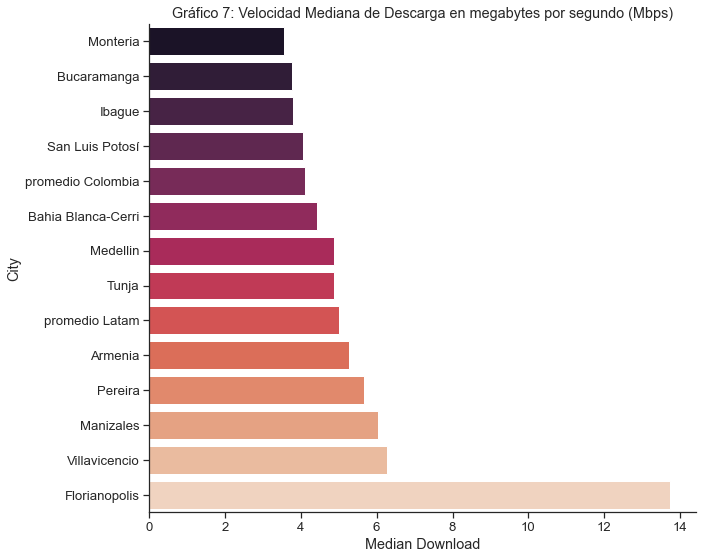

In [807]:
fig, ax = plt.subplots(figsize=(10,8)) #,constrained_layout=True
sns.barplot(x='Median Download', y=mlab_plot.sort_values('Median Download').index, data=mlab_plot.sort_values('Median Download') , palette='rocket' , orient='h' ).set_title('Gráfico 7: Velocidad Mediana de Descarga en megabytes por segundo (Mbps)')

sns.set(font_scale=1.2)
sns.set_style("ticks")
sns.despine()
plt.savefig("C:/Users/Franco/Python/CAF/Entregables/Informes/manizales 2/informe/images/descarga.png",bbox_inches='tight')
plt.tight_layout()

Aeropuerto mas cercano

In [68]:
#air_data = pd.read_csv('https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports-extended.dat', header = None)

In [69]:
#air_data.columns = ['Airport ID', 'Name','City','Country','IATA','ICAO','Latitude','Longitude','Altitude','Timezone','DST', 
#                    'Tz database time zone', 'Type','Source']


In [192]:
#air_data['Airport ID'] = air_data['Airport ID'].astype('str')
#air_data.loc[air_data['Name'].str.lower().str.contains('international'),'int'] = 1
#air_data.loc[~air_data['Name'].str.lower().str.contains('international'),'int'] = 0

In [193]:
#airports = gpd.GeoDataFrame(air_data, geometry=gpd.points_from_xy(air_data.Longitude, air_data.Latitude))

In [194]:
#airports.reset_index(inplace=True)

#airports.set_index(['Country' , 'City' ],inplace=True)

#airports.sort_index(inplace=True)

In [203]:
#airports.to_csv('C:/Users/Franco/Python/CAF/files/airports/airports.csv')

In [860]:
airports = pd.read_csv('C:/Users/Franco/Python/CAF/files/airports/airports.csv')

utm

In [305]:
latlongs['utm'] = latlongs.apply(lambda row: utm.from_latlon(row['geometry'].y, row['geometry'].x),axis=1)

In [322]:
airports = airports.drop([1969, 9613, 9816, 11568],axis=0)

In [323]:
airports['utm'] = airports.apply(lambda row: utm.from_latlon(row['geometry'].y,row['geometry'].x), axis=1)

Aeropuertos más cercanos

In [195]:
#def min_dist(point, gdf):
#    gdf['Dist'] = gdf.apply(lambda row: point.distance(row.geometry),axis=1)
#    a = gdf.iloc[gdf['Dist'].argmin()]['Airport ID']
#    return a

In [206]:
#def min_dist2(point, gdf):
#    a = gdf.apply(lambda row: point.distance(row.geometry),axis=1)
#    return a.argmin()

In [360]:
#latlongs['near_airport'] = latlongs.apply(lambda row: min_dist(row.geometry,airports),axis=1)

In [207]:
#latlongs['distance_airp'] = latlongs.apply(lambda row: min_dist2(row.geometry,airports),axis=1)

In [861]:
airports.loc[(airports['City']=='Manizales'),]

Unnamed: 0  index  Airport ID              Name       City   Country  \
2608        2608   2608        2733  La Nubia Airport  Manizales  Colombia   

     IATA  ICAO  Latitude  Longitude  Altitude Timezone DST  \
2608  MZL  SKMZ       5.0      -75.5      6871       -5   U   

     Tz database time zone     Type       Source  int  \
2608        America/Bogota  airport  OurAirports  0.0   

                               geometry  Dist  
2608  POINT (-75.46469999999999 5.0296)  42.2

In [350]:
geod = Geodesic.WGS84

In [369]:
def min_dist3(point, gdf):
    a = gdf.apply(lambda row: geod.Inverse(point.y, point.x, row['geometry'].y , row['geometry'].x)['s12'] ,axis=1)
    return a.argmin()

In [370]:
latlongs['distance_airp'] = latlongs.apply(lambda row: min_dist3(row.geometry,airports),axis=1)

KeyboardInterrupt: 

### Acceso a mercados

tabla

In [118]:
tabla = distances.loc[(distances['City A']=='Manizales')&(distances['duration_traffic']<5),['Country','City A','City B','Distance','duration_traffic']].rename(columns={'City B':'City'}).set_index(['Country','City']).join(merge.iloc[:,np.r_[0,1,2,3,-3,-2,-1]],how='left')

In [119]:
tabla = tabla.rename(columns={'Distance':'Distancia','duration_traffic':'horas de viaje en tráfico'}).drop(columns=['City A']).sort_values('horas de viaje en tráfico')

In [120]:
tabla = tabla.droplevel(0).reset_index().rename(columns={'City':'Ciudad'}).set_index('Ciudad')

In [127]:
#r'C:\Users\Franco\Python\CAF\Entregables\Informes\manizales 2\informe\images\tabla6.html'
BeautifulSoup(tabla.to_html(justify='left'), 'html.parser')#.prettify()

#<p style="text-align: center;">Tabla 6: Ciudades Cercanas</p>

<table border="1" class="dataframe">
<thead>
<tr style="text-align: left;">
<th></th>
<th>Distancia</th>
<th>horas de viaje en tráfico</th>
<th>Población estimada (millones)</th>
<th>Salario Horario (PPP 2011)</th>
<th>Tasa de Desempleo</th>
<th>% población con secundario completo</th>
<th>Ratio Agro</th>
<th>Ratio Ind Baja</th>
<th>Ratio Resto Ind</th>
</tr>
<tr>
<th>Ciudad</th>
<th></th>
<th></th>
<th></th>
<th></th>
<th></th>
<th></th>
<th></th>
<th></th>
<th></th>
</tr>
</thead>
<tbody>
<tr>
<th>Pereira</th>
<td>52.4 km</td>
<td>1.083</td>
<td>0.591</td>
<td>3.289</td>
<td>7.636</td>
<td>37.533</td>
<td>1.016</td>
<td>1.449</td>
<td>1.163</td>
</tr>
<tr>
<th>Cartago</th>
<td>79.8 km</td>
<td>1.667</td>
<td>nan</td>
<td>nan</td>
<td>nan</td>
<td>nan</td>
<td>nan</td>
<td>nan</td>
<td>nan</td>
</tr>
<tr>
<th>Armenia</th>
<td>97.6 km</td>
<td>2.000</td>
<td>2.960</td>
<td>3.393</td>
<td>7.870</td>
<td>36.443</td>
<td>1.363</td>
<td>0.724</td>
<td>0.826</td>
</tr>
<tr>
<th>Tulua</th>
<

In [223]:
#pd.set_option('colheader_justify', 'center')   # FOR TABLE <th>

#html_string = '''
#<html>
#  <head><title>Tabla 6: Ciudades cercanas</title></head>
#  <link rel="stylesheet" type="text/css" href="files/df_style.css"/>
#  <body>
#    {table}
#  </body>
#</html>.
#'''

# OUTPUT AN HTML FILE
#with open('informe/images/tabla6.html', 'w') as f:
#    f.write(html_string.format(table=tabla.to_html(classes='mystyle')))

'\n<p style="text-align: center;">Tabla 6: Ciudades Cercanas</p>\n<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: center;">\n      <th></th>\n      <th>Distancia</th>\n      <th>horas de viaje en tráfico</th>\n      <th>Población estimada (millones)</th>\n      <th>Salario Horario (PPP 2011)</th>\n      <th>Tasa de Desempleo</th>\n      <th>% población con secundario completo</th>\n      <th>Ratio Agro</th>\n      <th>Ratio Ind Baja</th>\n      <th>Ratio Resto Ind</th>\n    </tr>\n    <tr>\n      <th>Ciudad</th>\n      <th></th>\n      <th></th>\n      <th></th>\n      <th></th>\n      <th></th>\n      <th></th>\n      <th></th>\n      <th></th>\n      <th></th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <th>Pereira</th>\n      <td>52.4 km</td>\n      <td>1.08</td>\n      <td>0.59</td>\n      <td>3.29</td>\n      <td>7.64</td>\n      <td>37.53</td>\n      <td>1.02</td>\n      <td>1.45</td>\n      <td>1.16</td>\n    </tr>\n    <tr>\n      <th>Cartago<

Grafico

In [792]:
sc = shares_cutoff.drop(columns=['index1'])

In [794]:
medias = sc.loc['Colombia'].mean().to_frame().T.append(sc.mean().to_frame().T) #.reset_index() #.rename(columns={'index':'horas',0:'% de masa salarial'})

In [795]:
medias['City'] = ['promedio Colombia','promedio Latam']
medias['Country'] = ['promedio','promedio']

In [796]:
medias = medias.set_index(['Country','City'])

In [797]:
sc = sc.append(medias)

In [799]:
mydict = dict(zip(['cutoff_{}'.format(e) for e in range(10)],[e for e in range(10)]))

In [800]:
sc = sc.stack().reset_index().rename(columns={'level_2':'horas',0:'% de masa salarial'}).replace(mydict).set_index('City')

In [808]:
ref_com = [
'Manizales'
,'Pereira'
,'Medellin'
,'Armenia'
,'Villavicencio'
,'Monteria'
,'promedio Latam'
,'promedio Colombia'
,'Bahia Blanca-Cerri'
,'Florianopolis'
,'San Luis Potosí']

In [809]:
sc_acc = sc.loc[sc.index.isin(ref_com)]

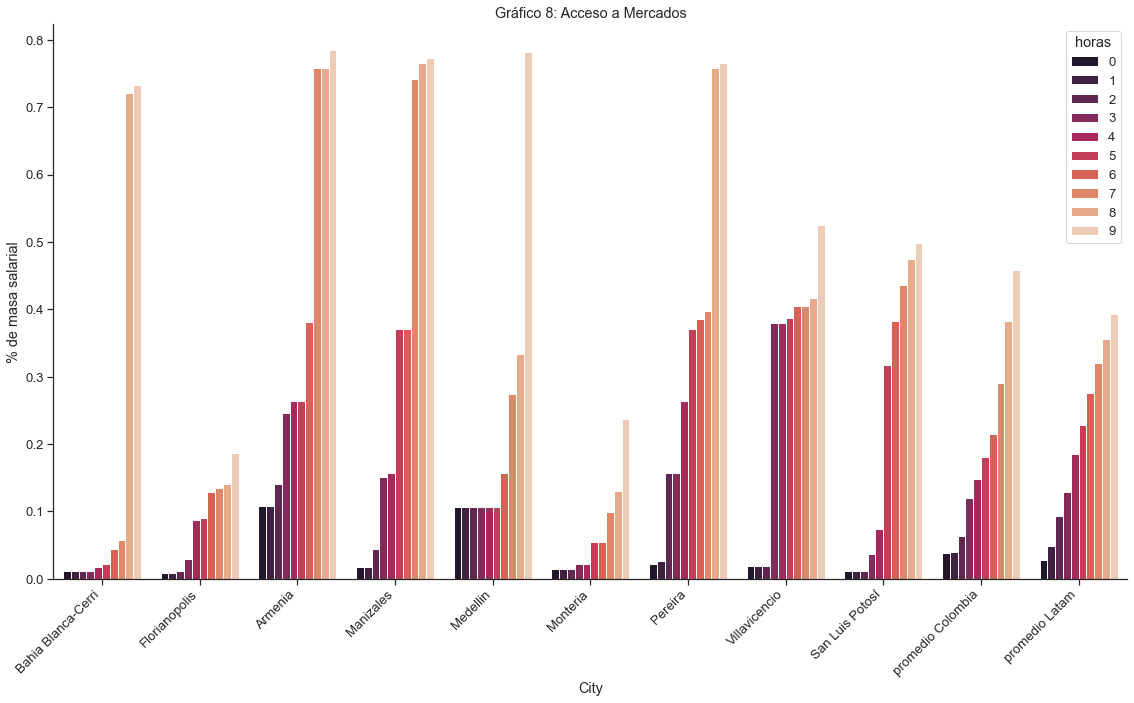

In [811]:
fig, ax = plt.subplots(figsize=(16,10)) #,constrained_layout=True
g = sns.barplot(x=sc_acc.index, y="% de masa salarial", hue='horas', data=sc_acc , palette='rocket' , linewidth=1)

g.set_title('Gráfico 8: Acceso a Mercados')
#g.legend_.remove()
g.set_xticklabels(sc_acc.index.unique().tolist() , rotation=45 , ha='right')

sns.set(font_scale=1.2)
sns.set_style("ticks")
sns.despine()
plt.savefig("C:/Users/Franco/Python/CAF/Entregables/Informes/manizales 2/informe/images/acceso.png",bbox_inches='tight')
plt.tight_layout()

### Conectividad Interna

mlab

Biggest obstacle transport

In [641]:
es_latam = es[es['Economy'].isin(['Argentina','Brazil','Mexico','Colombia','Ecuador','Peru','Uruguay','Paraguay','Panama','Costa Rica','Chile'])]

In [644]:
es_city = es_latam[es_latam['Subgroup']=='Location']

In [649]:
es_city = es_city.rename(columns={'Economy':'Country','Subgroup Level':'City'}).set_index(['Country','City'])

In [664]:
es_city['Year'] = es_city['Year'].astype('int')

In [672]:
keep = es_city.groupby('Country')['Year'].max().reset_index()

In [701]:
es_city = es_city.reset_index().loc[:,['Country','City','Year','Percent of firms choosing transportation as their biggest obstacle']].merge(keep,how='inner',on=['Country','Year']).drop(index=10).reset_index()

In [705]:
es_city = es_city.reset_index().drop(columns='index')

In [706]:
es_city[es_city.columns[-1]] = es_city[es_city.columns[-1]].astype('float')

In [712]:
media = es_city.mean().to_frame().T

In [719]:
media['Country'] = ['promedio Latam']

In [723]:
media.Year = media.Year.astype('int')

In [726]:
media[media.columns[-2]] = media[media.columns[-2]].astype('float')

In [728]:
plot = es_city.groupby(['Country']).mean().append(media.set_index('Country'))

In [729]:
plot

Year  \
Country                
Argentina       2017   
Brazil          2009   
Chile           2010   
Colombia        2017   
Costa Rica      2010   
Ecuador         2017   
Mexico          2010   
Panama          2010   
Paraguay        2017   
Peru            2017   
Uruguay         2017   
promedio Latam  2012   

                Percent of firms choosing transportation as their biggest obstacle  
Country                                                                             
Argentina                                                     1.9                   
Brazil                                                        0.9                   
Chile                                                         7.1                   
Colombia                                                      1.4                   
Costa Rica                                                    1.4                   
Ecuador                                                       0.7                   
Mexico                                                        1.9                   
Panama                                                        0.3                   
Paraguay                                                      5.1                   
Peru                                                          3.4                   
Uruguay                                                       5.4                   
promedio Latam                                                2.2

### Trabajo y Conocimiento

In [894]:
es_latam.loc[(es_latam['Economy']=='Colombia')&(es_latam['Year']==2017)]

Economy    Year               Subgroup Top Subgroup Level  \
1180  Colombia 2,017.0                    NaN                NaN   
1181  Colombia 2,017.0                 Sector      Manufacturing   
1182  Colombia 2,017.0                 Sector      Manufacturing   
1183  Colombia 2,017.0                 Sector      Manufacturing   
1184  Colombia 2,017.0                 Sector      Manufacturing   
1185  Colombia 2,017.0                 Sector           Services   
1186  Colombia 2,017.0                 Sector           Services   
1187  Colombia 2,017.0                 Sector           Services   
1188  Colombia 2,017.0                   Size                NaN   
1189  Colombia 2,017.0                   Size                NaN   
1190  Colombia 2,017.0                   Size                NaN   
1191  Colombia 2,017.0               Location                NaN   
1192  Colombia 2,017.0               Location                NaN   
1193  Colombia 2,017.0               Location                NaN   
1194  Colombia 2,017.0               Location                NaN   
1195  Colombia 2,017.0               Location                NaN   
1196  Colombia 2,017.0          Exporter Type                NaN   
1197  Colombia 2,017.0          Exporter Type                NaN   
1198  Colombia 2,017.0  Gender of Top Manager                NaN   
1199  Colombia 2,017.0  Gender of Top Manager                NaN   
1200  Colombia 2,017.0         Ownership Type                NaN   
1201  Colombia 2,017.0         Ownership Type                NaN   

                               Subgroup Level Average/SE/N  \
1180                                      NaN      Average   
1181                                      All      Average   
1182                                     Food      Average   
1183                      Textiles & Garments      Average   
1184                      Other Manufacturing      Average   
1185                                      All      Average   
1186                                   Retail      Average   
1187                           Other Services      Average   
1188                             Small (5-19)      Average   
1189                           Medium (20-99)      Average   
1190                             Large (100+)      Average   
1191                             Barranquilla      Average   
1192                                   Bogota      Average   
1193                                     Cali      Average   
1194                                Cartagena      Average   
1195                                 Medellin      Average   
1196  Direct exports are 10% or more of sales      Average   
1197                             Non-exporter      Average   
1198                    Top manager is female      Average   
1199                      Top manager is male      Average   
1200                                 Domestic      Average   
1201            10% or more foreign ownership      Average   

     Percent of firms choosing access to finance as their biggest obstacle  \
1180                                                7.5                      
1181                                                4.9                      
1182                                                6.3                      
1183                                                4.5                      
1184                                                4.8                      
1185                                                8.5                      
1186                                               11.5                      
1187                                                7.7                      
1188                                                8.2                      
1189                                                7.7                      
1190                                                2.7                      
1191                                                7.4                      
1

In [901]:
k = es_latam.groupby('Economy')['Year'].max().reset_index()

In [906]:
avg_con = es_latam.merge(k,how='inner',on=['Economy','Year']).groupby('Economy').head(1)

In [915]:
avg_con[avg_con.columns[6:]] = avg_con[avg_con.columns[6:]].apply(pd.to_numeric, downcast='float')

In [927]:
avg_con.loc[:,['Economy','Year','Percent of firms choosing inadequately educated workforce as their biggest obstacle']].mean()

Year                                                                                  2,013.7
Percent of firms choosing inadequately educated workforce as their biggest obstacle      10.2
dtype: float64

In [931]:
es_latam.merge(k,how='inner',on=['Economy','Year']).loc[:,['Economy','Subgroup Level','Percent of firms choosing inadequately educated workforce as their biggest obstacle']]

Economy                                     Subgroup Level  \
0     Argentina                                                NaN   
1     Argentina                                                All   
2     Argentina                                               Food   
3     Argentina                                Textiles & Garments   
4     Argentina                                Other Manufacturing   
5     Argentina                                                All   
6     Argentina                                             Retail   
7     Argentina                                     Other Services   
8     Argentina                                       Small (5-19)   
9     Argentina                                     Medium (20-99)   
10    Argentina                                       Large (100+)   
11    Argentina                                       Buenos Aires   
12    Argentina                                            Cordoba   
13    Argentina                                            Mendoza   
14    Argentina                                            Rosario   
15    Argentina                                            Tucuman   
16    Argentina            Direct exports are 10% or more of sales   
17    Argentina                                       Non-exporter   
18    Argentina                              Top manager is female   
19    Argentina                                Top manager is male   
20    Argentina                                           Domestic   
21    Argentina                      10% or more foreign ownership   
22       Brazil                                                NaN   
23       Brazil                                                All   
24       Brazil                                               Food   
25       Brazil                                           Textiles   
26       Brazil                                           Garments   
27       Brazil                                   Leather Products   
28       Brazil                      Chemicals & Chemical Products   
29       Brazil                              Machinery & Equipment   
30       Brazil                                     Motor Vehicles   
31       Brazil                                          Furniture   
32       Brazil                                Other Manufacturing   
33       Brazil                                                All   
34       Brazil                                             Retail   
35       Brazil                                   IT & IT Services   
36       Brazil                                     Other Services   
37       Brazil                                     Medium (20-99)   
38       Brazil                                       Small (5-19)   
39       Brazil                                       Large (100+)   
40       Brazil                                           Amazonas   
41       Brazil                                              Bahia   
42       Brazil                                        Brasilia DF   
43       Brazil                                              Ceara   
44       Brazil                                              Goias   
45       Brazil                                           Maranhao   
46       Brazil                                        Mato Grosso   
47       Brazil                                       Minas Gerais   
48       Brazil                                            Paraiba   
49       Brazil                                             Parana   
50       Brazil                                         Pernambuco   
51       Brazil                                     Rio de Janeiro   
52       Brazil                                  Rio Grande do Sul   
53       Brazil                                     Santa Catarina   
54       Brazil                                          Sao Paulo   
55       Brazil            Direct exports are 10% or more of sales   
56       Brazil   

EPH

In [67]:
medias = eph.reset_index().loc[eph.reset_index()['City'].str.contains('(total ciudades)|(Total Ciudades)')]

In [68]:
info = eph[eph.columns[1:4]]

In [69]:
desempleo = eph[eph.columns[7:19]]

In [70]:
dist_asa = eph[eph.columns[19:24]]

In [71]:
edu = eph[eph.columns[24:]]

In [86]:
act = eph.loc[:,eph.columns[4:7].tolist()]

Act

In [87]:
ref_com = [
'Manizales'
,'Pereira'
,'Medellin'
,'Armenia'
,'Villavicencio'
,'Monteria'
,'Bucaramanga'
,'Ibague'
,'Tunja'
,'promedio Latam'
,'promedio Colombia'
,'Bahia Blanca-Cerri'
,'Florianopolis']

In [88]:
act.columns=['Tasa actividad Total','Tasa actividad Mujeres','Tasa actividad Hombres']

In [89]:
actm = act.reset_index().loc[act.reset_index()['City'].str.contains('(total ciudades)',regex=False)].mean().to_frame().T.append(act.loc[('Colombia','Colombia 2018 (Total Ciudades)')].to_frame(0).T)

In [90]:
actm['City'] = ['promedio Latam','promedio Colombia']

In [91]:
actm['Country'] = ['promedio','promedio']

In [92]:
act = act.append(actm.set_index(['Country','City']))

In [93]:
act_plot = act.loc[idx[:,ref_com],:].droplevel(0)

In [95]:
act_plot['Diferencia Tasa A. Hombres - Tasa A. Mujeres'] = act_plot['Tasa actividad Hombres'] - act_plot['Tasa actividad Mujeres']

In [96]:
act_plot = act_plot.sort_values('Diferencia Tasa A. Hombres - Tasa A. Mujeres')

In [101]:
act_plot.columns

Index(['Tasa actividad Total', 'Tasa actividad Mujeres',
       'Tasa actividad Hombres',
       'Diferencia Tasa A. Hombres - Tasa A. Mujeres'],
      dtype='object')

In [106]:
plot = act_plot.drop(columns=['Tasa actividad Hombres','Tasa actividad Mujeres']).stack().reset_index().rename(columns={'level_1':'Sexo',0:'Tasa de Actividad'}).set_index('City').sort_values(['Sexo','Tasa de Actividad'],ascending=[False,True]) #

In [83]:
#plot = act_plot.stack().reset_index().rename(columns={'level_1':'Sexo',0:'Tasa de Actividad'}).set_index('City').sort_values(['City','Sexo']) #.drop(columns='Tasa actividad Total')

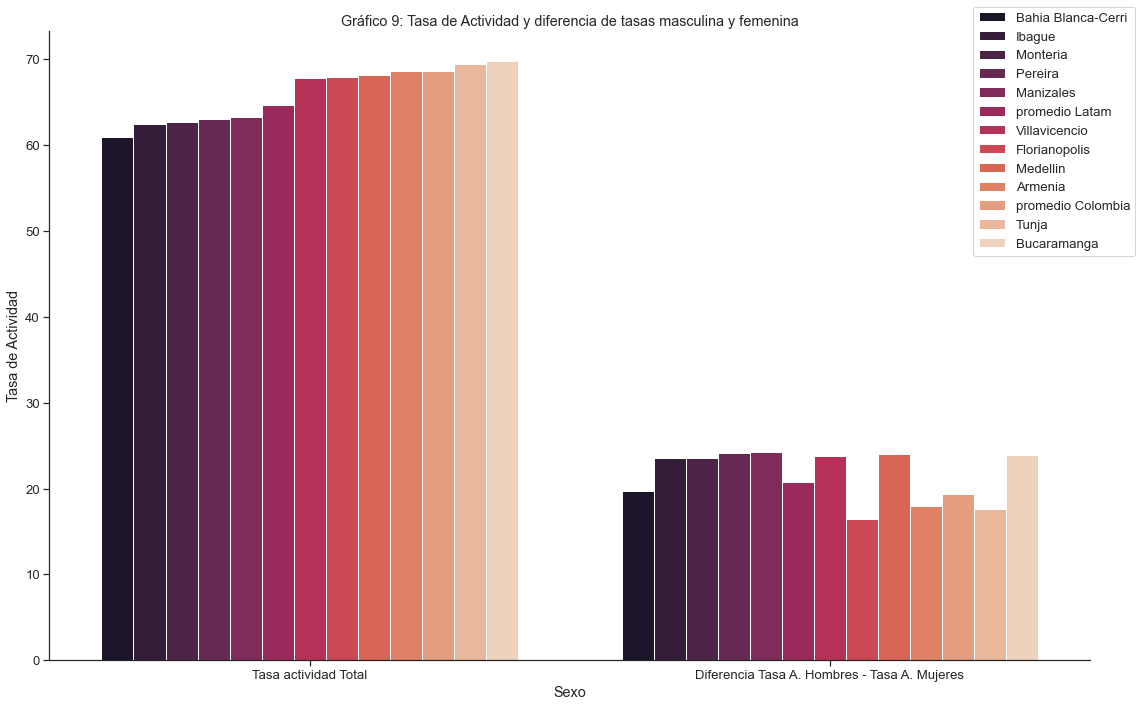

In [110]:
fig, ax = plt.subplots(figsize=(16,10)) #,constrained_layout=True
g = sns.barplot(x="Sexo", y="Tasa de Actividad", hue=plot.index, data=plot , palette='rocket' , linewidth=1)

g.set_title('Gráfico 9: Tasa de Actividad y diferencia de tasas masculina y femenina')
#g.legend_.remove()
#g.set_xticklabels(plot.index.unique().tolist() , rotation=45 , ha='right')

sns.set(font_scale=1.2)
sns.set_style("ticks")
sns.despine()
plt.legend(bbox_to_anchor=(1.05,1.05), loc="upper right")
plt.savefig("C:/Users/Franco/Python/CAF/Entregables/Informes/manizales 2/informe/images/actividad.png",bbox_inches='tight')
plt.tight_layout()

Dist Asalariados

In [111]:
searchfor = ['total', 'Total']
dis = dist_asa.reset_index().loc[dist_asa.reset_index()['City'].str.contains('|'.join(searchfor))].mean().to_frame().T

dis['City'] = ['promedio Latam']

dis['Country'] = ['promedio']

dis = dis.set_index(['Country','City'])

In [112]:
dist_asa = dist_asa.append(dis)

In [113]:
a = dist_asa.loc[idx[:,ref_com + ['Colombia 2018 (Total Ciudades)']],:].drop(columns=('Distribución de ocupados según relación laboral', 'Asalariado  (total)'))

In [114]:
a = a.reset_index().replace({('City', ''):{'Colombia 2018 (Total Ciudades)':'promedio Colombia'}}).set_index(['Country','City'])

In [115]:
a.columns = a.columns.droplevel()
a = a.droplevel(0)

In [116]:
a = a.sort_values('Asalariado (privado)')

In [117]:
a

Asalariado (público)  Asalariado (privado)  \
City                                                             
Armenia                             5.81                 23.44   
Bucaramanga                         5.21                 26.37   
Ibague                              4.74                 28.14   
Pereira                             5.01                 28.47   
Manizales                           3.92                 32.62   
Medellin                            4.87                 39.64   
promedio Colombia                   4.55                 47.81   
Villavicencio                       4.88                 51.15   
Tunja                               3.39                 52.92   
Monteria                            7.58                 53.65   
promedio Latam                     12.96                 54.28   
Bahia Blanca-Cerri                 17.68                 54.95   
Florianopolis                      11.09                 63.25   

                    Patrón o Cuentapropista  Sin salario  
City                                                      
Armenia                               65.69         5.06  
Bucaramanga                           64.01         4.41  
Ibague                                64.37         2.76  
Pereira                               63.35         3.18  
Manizales                             59.95         3.51  
Medellin                              52.49         2.99  
promedio Colombia                     45.33         2.30  
Villavicencio                         41.20         2.77  
Tunja                                 41.78         1.91  
Monteria                              37.06         1.70  
promedio Latam                        30.20         2.56  
Bahia Blanca-Cerri                    26.99         0.38  
Florianopolis                         25.10         0.56

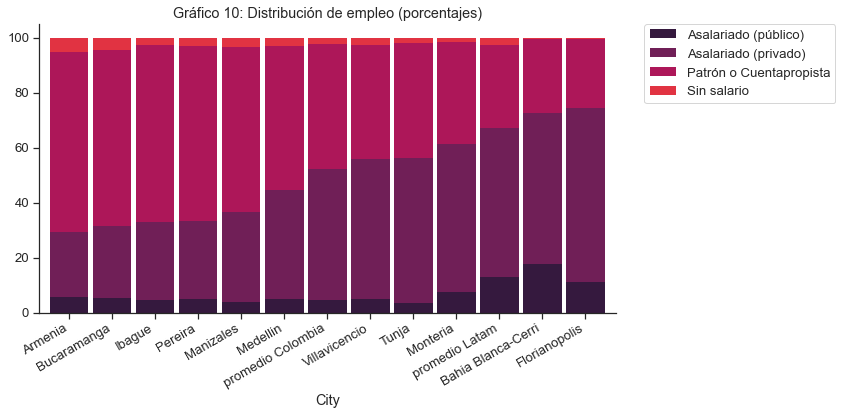

In [972]:
sns.set_palette('rocket')

fig, ax = plt.subplots(1, 1,figsize=(12,6))

a.plot(kind='bar', stacked=True , ax=ax , color=sns.color_palette() , width=0.9 , linewidth=0.001).set_title('Gráfico 10: Distribución de empleo (porcentajes)')

fig.autofmt_xdate()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tight_layout()
plt.savefig("C:/Users/Franco/Python/CAF/Entregables/Informes/manizales 2/informe/images/empleo_dist.png",bbox_inches='tight')

Info y desempleo

In [118]:
info.columns = info.columns.droplevel()

In [119]:
inf_des = info.loc[:,'Total'].to_frame().rename(columns={'Total':'Informalidad'}).join(desempleo.iloc[:,0]).rename(columns={('Tasa de Desempleo','Total'):'Desempleo'})

In [120]:
searchfor = ['total', 'Total']
in_des_m = inf_des.reset_index().loc[inf_des.reset_index()['City'].str.contains('|'.join(searchfor))].mean().to_frame().T.append(inf_des.loc[('Colombia','Colombia 2018 (Total Ciudades)')].to_frame(0).T)

In [121]:
in_des_m['City'] = ['promedio Latam','promedio Colombia']

In [122]:
in_des_m['Country'] = ['promedio','promedio']

In [123]:
in_des_m = in_des_m.set_index(['Country','City'])

In [124]:
idp = inf_des.loc[idx[:,ref_com],:].append(in_des_m).stack().reset_index().rename(columns={'level_2':'Variable',0:'Porcentaje'}).set_index(['Country','City']).droplevel(0).sort_values('City')

In [126]:
idp.sort_values(['Variable','Porcentaje'])

Variable  Porcentaje
City                                        
Florianopolis          Desempleo        6.51
Manizales              Desempleo        6.76
promedio Latam         Desempleo        7.54
Pereira                Desempleo        7.64
Armenia                Desempleo        7.87
Villavicencio          Desempleo        8.24
Bahia Blanca-Cerri     Desempleo        9.01
Bucaramanga            Desempleo        9.82
promedio Colombia      Desempleo       10.57
Monteria               Desempleo       10.99
Tunja                  Desempleo       11.66
Ibague                 Desempleo       12.09
Medellin               Desempleo       13.90
Florianopolis       Informalidad       10.31
Medellin            Informalidad       27.66
Manizales           Informalidad       27.92
Bahia Blanca-Cerri  Informalidad       29.32
promedio Colombia   Informalidad       29.60
Monteria            Informalidad       29.83
Ibague              Informalidad       30.50
Armenia             Informalidad       31.33
Tunja               Informalidad       31.79
Pereira             Informalidad       31.84
Villavicencio       Informalidad       35.29
promedio Latam      Informalidad       38.84
Bucaramanga         Informalidad       43.28

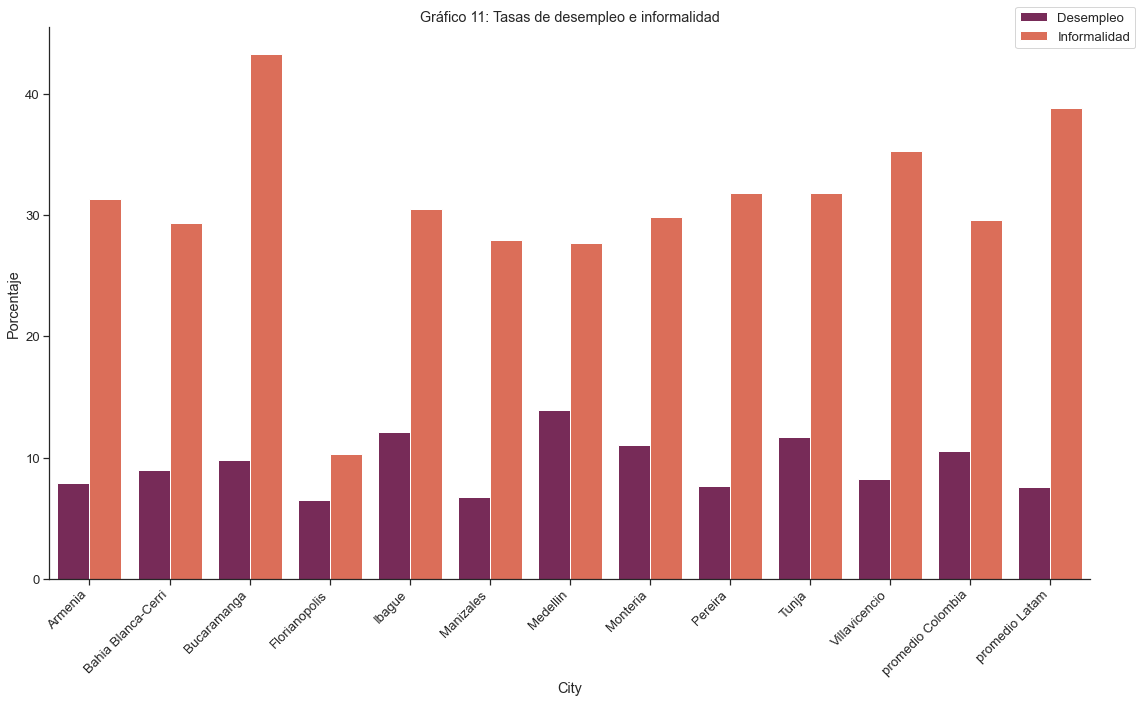

In [1064]:
fig, ax = plt.subplots(figsize=(16,10)) #,constrained_layout=True
g = sns.barplot(x=idp.index, y='Porcentaje', hue='Variable', data=idp , palette='rocket' , linewidth=1)

g.set_title('Gráfico 11: Tasas de desempleo e informalidad')
#g.legend_.remove()
g.set_xticklabels(idp.index.unique().tolist() , rotation=45 , ha='right')

sns.set(font_scale=1.2)
sns.set_style("ticks")
sns.despine()
plt.legend(bbox_to_anchor=(1.05,1.05), loc="upper right")
plt.savefig("C:/Users/Franco/Python/CAF/Entregables/Informes/manizales 2/informe/images/inf_des.png",bbox_inches='tight')
plt.tight_layout()

desempleo etario

In [127]:
searchfor = ['total', 'Total']
des = desempleo.reset_index().loc[desempleo.reset_index()['City'].str.contains('|'.join(searchfor))].mean().to_frame().T.append(desempleo.loc[('Colombia','Colombia 2018 (Total Ciudades)')].to_frame(0).T)

des['City'] = ['promedio Latam','promedio Colombia']

des['Country'] = ['promedio','promedio']

des = des.set_index(['Country','City'])

In [128]:
desempleo = desempleo.append(des)

In [129]:
des_plot = desempleo.loc[idx[:,ref_com],desempleo.columns[3:6].tolist()].droplevel(0,axis=1).stack().to_frame().reset_index().rename(columns={'level_2':'Rango Etario',0:'Porcentaje'}).set_index(['Country','City']).droplevel(0).sort_values(['City','Rango Etario'])

In [130]:
#des_plot

Rango Etario  Porcentaje
City                                       
Armenia                   15-24       12.32
Armenia                   25-54        7.68
Armenia                  55 (+)        3.33
Bahia Blanca-Cerri        15-24       30.30
Bahia Blanca-Cerri        25-54        7.16
Bahia Blanca-Cerri       55 (+)        4.08
Bucaramanga               15-24       21.85
Bucaramanga               25-54        8.23
Bucaramanga              55 (+)        3.12
Florianopolis             15-24       15.50
Florianopolis             25-54        4.74
Florianopolis            55 (+)        3.11
Ibague                    15-24       22.00
Ibague                    25-54       10.94
Ibague                   55 (+)        5.29
Manizales                 15-24       14.83
Manizales                 25-54        6.20
Manizales                55 (+)        1.94
Medellin                  15-24       23.91
Medellin                  25-54       11.16
Medellin                 55 (+)       12.69
Monteria                  15-24       22.85
Monteria                  25-54        9.55
Monteria                 55 (+)        5.03
Pereira                   15-24       17.12
Pereira                   25-54        6.64
Pereira                  55 (+)        1.75
Tunja                     15-24       22.65
Tunja                     25-54        9.85
Tunja                    55 (+)        6.68
Villavicencio             15-24       17.64
Villavicencio             25-54        6.89
Villavicencio            55 (+)        3.72
promedio Colombia         15-24       22.11
promedio Colombia         25-54        8.84
promedio Colombia        55 (+)        5.45
promedio Latam            15-24       18.80
promedio Latam            25-54        5.97
promedio Latam           55 (+)        3.86

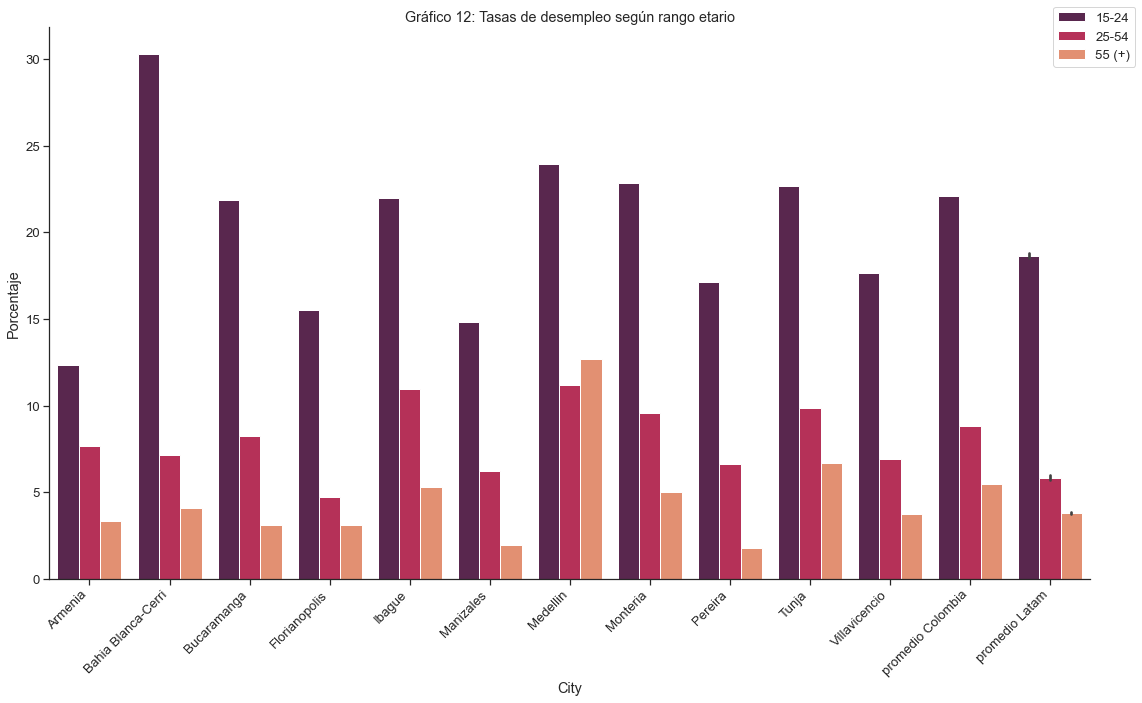

In [1110]:
fig, ax = plt.subplots(figsize=(16,10))
g = sns.barplot(x=des_plot.index, y='Porcentaje', hue='Rango Etario', data=des_plot , palette='rocket' , linewidth=1)

g.set_title('Gráfico 12: Tasas de desempleo según rango etario')
#g.legend_.remove()
g.set_xticklabels(des_plot.index.unique().tolist() , rotation=45 , ha='right')

sns.set(font_scale=1.2)
sns.set_style("ticks")
sns.despine()
plt.legend(bbox_to_anchor=(1.05,1.05), loc="upper right")
plt.savefig("C:/Users/Franco/Python/CAF/Entregables/Informes/manizales 2/informe/images/des_etario.png",bbox_inches='tight')
plt.tight_layout()

Educación

In [131]:
edup = edu.loc[:,[('% población con secundario completo', 'Total'),('% población con secundario completo',
 '% población 18-25 años  que se encuentra estudiando nivel superior o terciario'),('% población con superior completo', 'Total'),('% población con superior completo', '25 a 35 años de edad')]]

In [132]:
edup.columns=['% población total con secundario completo','% entre 18-25 estudiando superior / terciario','% población total con superior terminado','% entre 25-35 con superior terminado']

In [133]:
l = edup.columns.tolist()

In [134]:
l = [l[0]]+[l[2]]+[l[3]]+[l[1]]

In [135]:
edup = edup[l]

In [136]:
searchfor=['total','Total']
edum = edup.reset_index().loc[edup.reset_index()['City'].str.contains('|'.join(searchfor))].mean().to_frame().T.append(edup.loc[('Colombia','Colombia 2018 (Total Ciudades)')].to_frame(0).T)

edum['City'] = ['promedio Latam','promedio Colombia']

edum['Country'] = ['promedio','promedio']

edum = edum.set_index(['Country','City'])

In [137]:
edup = edup.append(edum)

In [138]:
edu_plot = edup.loc[idx[:,ref_com],['% población total con secundario completo','% población total con superior terminado']].droplevel(0).sort_values(['% población total con secundario completo'])

In [140]:
edu_plot.sort_values(edu_plot.columns[1])

% población total con secundario completo  \
City                                                            
Pereira                                                 37.53   
Ibague                                                  38.10   
Manizales                                               39.31   
Bucaramanga                                             35.88   
Medellin                                                39.63   
Armenia                                                 36.44   
Villavicencio                                           40.84   
Tunja                                                   44.02   
Monteria                                                42.43   
promedio Colombia                                       44.03   
promedio Latam                                          41.33   
Florianopolis                                           43.25   
Bahia Blanca-Cerri                                      49.04   

                    % población total con superior terminado  
City                                                          
Pereira                                                 7.21  
Ibague                                                  7.49  
Manizales                                               7.78  
Bucaramanga                                             7.79  
Medellin                                                7.86  
Armenia                                                 8.64  
Villavicencio                                           8.78  
Tunja                                                   9.16  
Monteria                                                9.88  
promedio Colombia                                      10.87  
promedio Latam                                         12.49  
Florianopolis                                          14.02  
Bahia Blanca-Cerri                                     15.71

[0.0, 50.0, 0.0, 50.0]

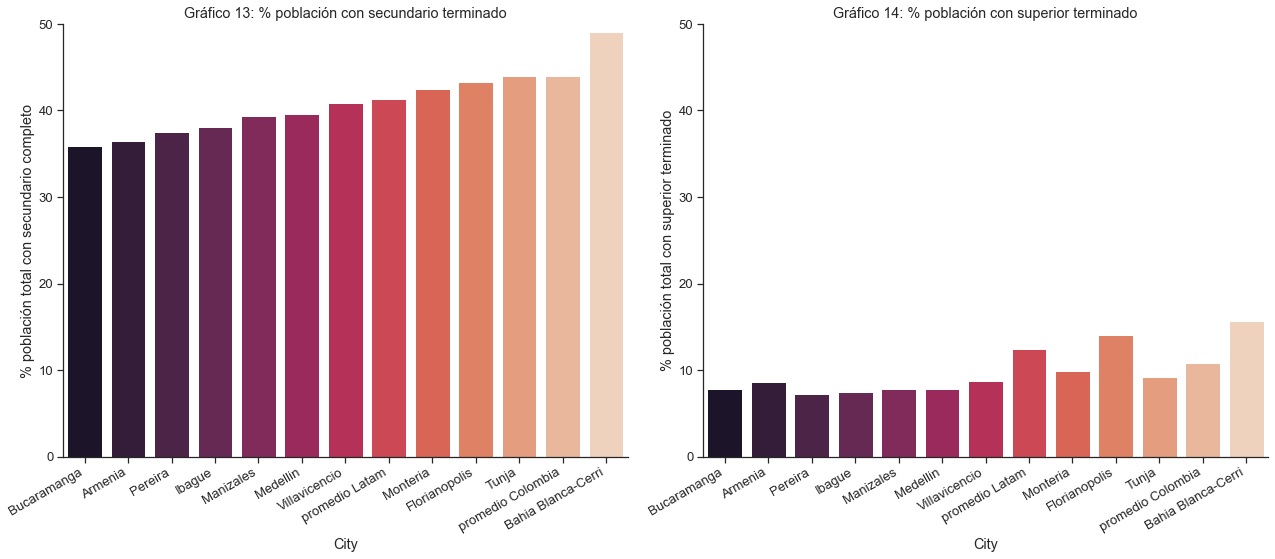

In [1141]:
fig, ax = plt.subplots(1, 2,figsize=(18,8))

sns.barplot(x=edu_plot.index, y='% población total con secundario completo', data=edu_plot, ax=ax[0], palette='rocket').set_title('Gráfico 13: % población con secundario terminado')
sns.barplot(x=edu_plot.index, y='% población total con superior terminado', data=edu_plot, ax=ax[1], palette='rocket').set_title('Gráfico 14: % población con superior terminado')

fig.autofmt_xdate()

sns.set(font_scale=1.2)
sns.set_style("ticks")
sns.despine()

plt.savefig("C:/Users/Franco/Python/CAF/Entregables/Informes/manizales 2/informe/images/edu_secundaria.png",bbox_inches='tight')
plt.tight_layout()
custom_ylim = (0, 50)
plt.setp(ax,  ylim=custom_ylim)

In [1132]:
edup.columns

Index(['% población total con secundario completo',
       '% población total con superior terminado',
       '% entre 25-35 con superior terminado',
       '% entre 18-25 estudiando superior / terciario'],
      dtype='object')

In [141]:
edu_plot2 = edup.loc[idx[:,ref_com],['% entre 25-35 con superior terminado','% entre 18-25 estudiando superior / terciario']].droplevel(0).stack().to_frame().reset_index().rename(columns={'level_1':'Grupo',0:'Porcentaje'}).set_index(['City']).sort_values(['City','Grupo'],ascending=[True,False])

In [142]:
#edu_plot2

Grupo  Porcentaje
City                                                                         
Armenia                      % entre 25-35 con superior terminado       19.33
Armenia             % entre 18-25 estudiando superior / terciario       19.53
Bahia Blanca-Cerri           % entre 25-35 con superior terminado       18.42
Bahia Blanca-Cerri  % entre 18-25 estudiando superior / terciario       48.85
Bucaramanga                  % entre 25-35 con superior terminado       18.14
Bucaramanga         % entre 18-25 estudiando superior / terciario       20.92
Florianopolis                % entre 25-35 con superior terminado       27.71
Florianopolis       % entre 18-25 estudiando superior / terciario       22.43
Ibague                       % entre 25-35 con superior terminado       15.97
Ibague              % entre 18-25 estudiando superior / terciario       18.51
Manizales                    % entre 25-35 con superior terminado       16.00
Manizales           % entre 18-25 estudiando superior / terciario       23.44
Medellin                     % entre 25-35 con superior terminado       15.23
Medellin            % entre 18-25 estudiando superior / terciario       18.52
Monteria                     % entre 25-35 con superior terminado       20.12
Monteria            % entre 18-25 estudiando superior / terciario       21.24
Pereira                      % entre 25-35 con superior terminado       13.95
Pereira             % entre 18-25 estudiando superior / terciario       14.94
Tunja                        % entre 25-35 con superior terminado       16.48
Tunja               % entre 18-25 estudiando superior / terciario       16.88
Villavicencio                % entre 25-35 con superior terminado       15.90
Villavicencio       % entre 18-25 estudiando superior / terciario       19.12
promedio Colombia            % entre 25-35 con superior terminado       21.01
promedio Colombia   % entre 18-25 estudiando superior / terciario       21.91
promedio Latam               % entre 25-35 con superior terminado       24.05
promedio Latam      % entre 18-25 estudiando superior / terciario       30.92

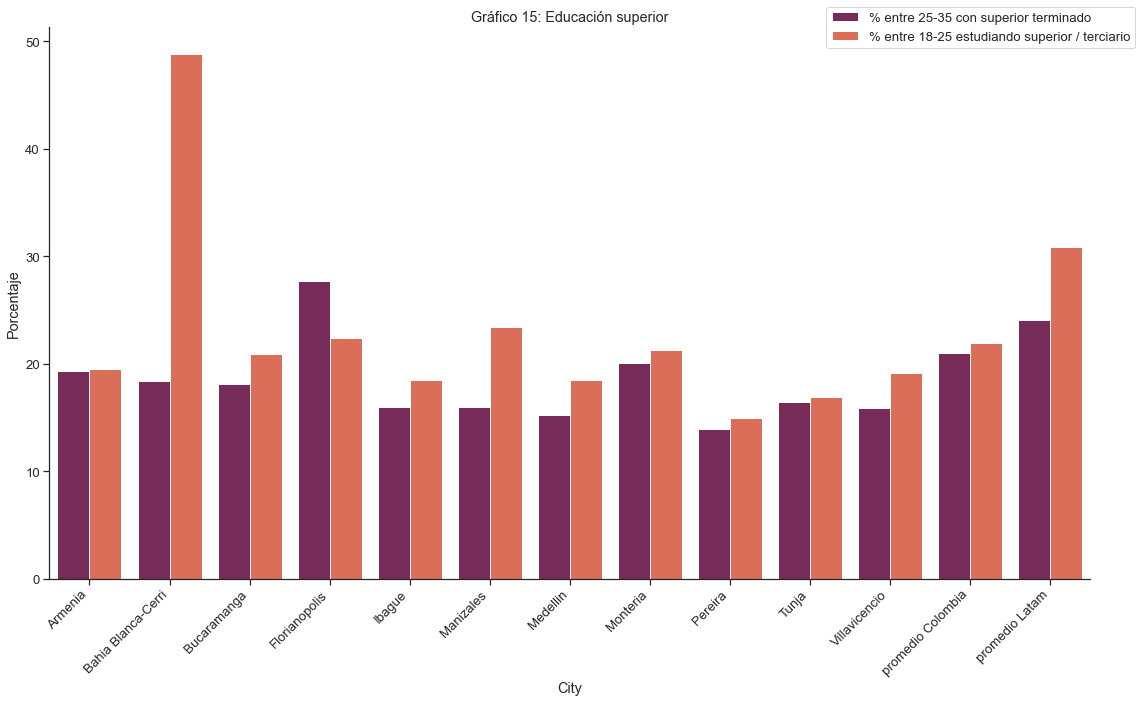

In [1144]:
fig, ax = plt.subplots(figsize=(16,10))
g = sns.barplot(x=edu_plot2.index, y='Porcentaje', hue='Grupo', data=edu_plot2 , palette='rocket' , linewidth=1)

g.set_title('Gráfico 15: Educación superior')
g.set_xticklabels(edu_plot2.index.unique().tolist() , rotation=45 , ha='right')

sns.set(font_scale=1.2)
sns.set_style("ticks")
sns.despine()
plt.legend(bbox_to_anchor=(1.05,1.05), loc="upper right")
plt.savefig("C:/Users/Franco/Python/CAF/Entregables/Informes/manizales 2/informe/images/edu_superior.png",bbox_inches='tight')
plt.tight_layout()

### Conglomerados y Cadenas de Valor

In [143]:
hh = ta.loc['Colombia',['HHc/HHp','HH','Hhpais']].join(eph.loc['Colombia',eph.columns[0]]).rename(columns={eph.columns[0]:'Salario Horario (USD)','HH':'Índice HH','HHc/HHp':'Índice HH / Índice HH país'}).join(ta.loc['Colombia',ta.columns[33:36].tolist()].idxmax(axis=1).to_frame().rename(columns={0:'Principal Sector (3 principales)'}))

In [144]:
hh = hh.reset_index()

In [145]:
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.005, point['y'], str(point['val']))

No handles with labels found to put in legend.


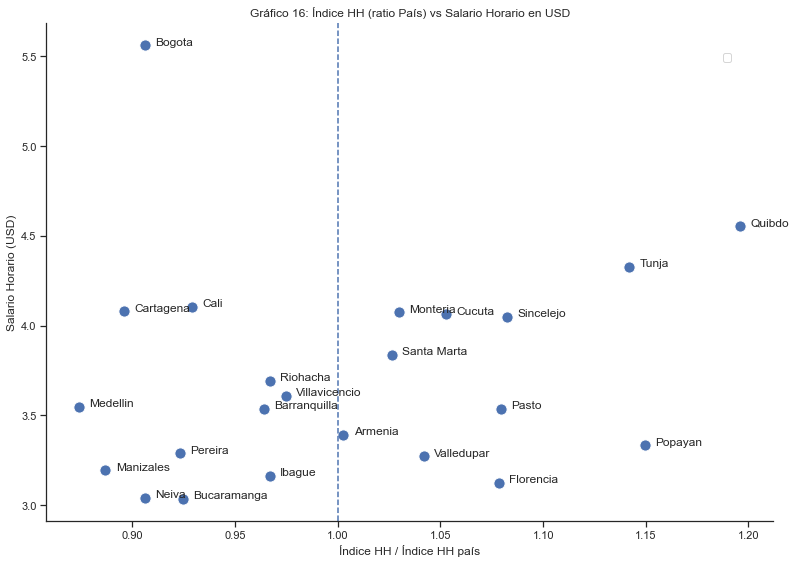

In [150]:
fig, ax = plt.subplots(figsize=(11,8))

sns.scatterplot(data=hh, x="Índice HH / Índice HH país", y="Salario Horario (USD)" , ax=ax  , s=125 , palette='rocket').set_title('Gráfico 16: Índice HH (ratio País) vs Salario Horario en USD') #, hue="Principal Sector (3 principales)",   size="Principal Sector (3 principales)" 


plt.legend(bbox_to_anchor=(0.95,0.95), loc="upper right")
plt.tight_layout()
sns.set(font_scale=1.0)
sns.set_style("ticks")
sns.despine()
plt.axvline(x=1,linestyle='--')

label_point( hh["Índice HH / Índice HH país"] , hh["Salario Horario (USD)"] , hh['City'] , plt.gca())

plt.savefig("C:/Users/Franco/Python/CAF/Entregables/Informes/manizales 2/informe/images/hh_salario.png",bbox_inches='tight')

Distribución de masa salarial, empleo y salarios

In [192]:
e = ta.iloc[:,12:22]

In [193]:
eplot = e.loc[idx[:,ref_com],:].droplevel(0)

In [194]:
eplot = eplot.rename(columns=dict(zip(eplot.columns.tolist(),[ta.columns[33:43].tolist()[e] for e in range(10)])))

In [195]:
eplot['df']='Empleo'

In [196]:
ms = ta.iloc[:,33:43]

In [197]:
msplot = ms.loc[idx[:,ref_com],:].droplevel(0)

In [198]:
msplot = msplot.rename(columns=dict(zip(msplot.columns.tolist(),[ta.columns[33:43].tolist()[e] for e in range(10)])))

In [199]:
msplot['df']='Masa Salarial'

In [200]:
df = pd.concat([pd.melt(eplot.reset_index(),id_vars=['df','City']),pd.melt(msplot.reset_index(),id_vars=['df','City'])],ignore_index=True)

In [201]:
df = df.set_index(['df','City','variable'])

In [202]:
df["vcs"] = df.groupby(level=["df","City"]).cumsum()

In [203]:
df = df.reset_index()

Plotly

In [204]:
cl = [e for e in sns.color_palette('rocket',10)]
cl2 = [(int(t[0]*255), int(t[1]*255) , int(t[2]*255)) for t in cl]
colors = ['#%02x%02x%02x' % e for e in cl2] 

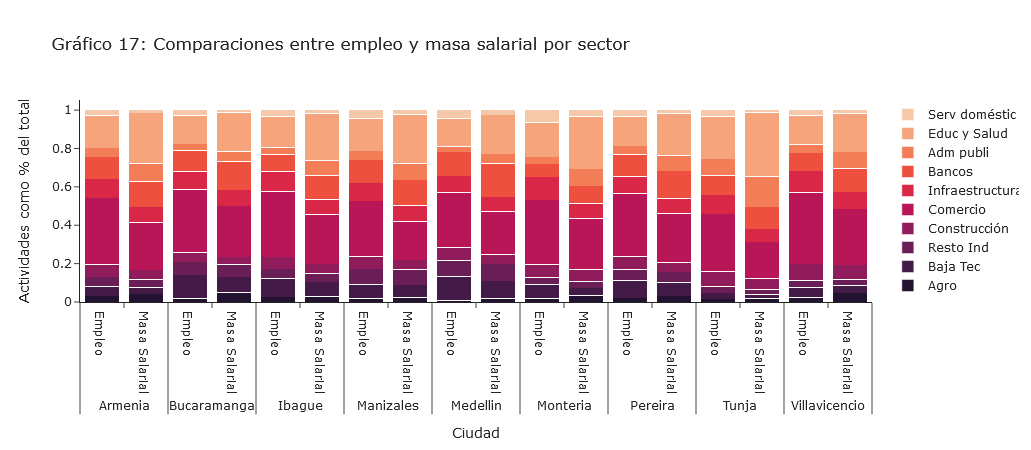

In [206]:
fig = go.Figure()

fig.update_layout(
    template="simple_white",
    xaxis=dict(title_text="Ciudad"),
    yaxis=dict(title_text="Actividades como % del total"),
    barmode="stack",
)


for r, c in zip(df.variable.unique(), colors):
    plot_df = df[df.variable == r]
    fig.add_trace(
        go.Bar(x=[plot_df.City, plot_df.df], y=plot_df.value, name=r, marker_color=c),
    )

#fig
#ig.write_html("fig.html")
#py.offline.plot(fig, include_plotlyjs="cdn", output_type='div') #filename='fig.html' include_plotlyjs="cdn"
#fig.write_image("images/empleovsms.png")
fig.update_layout(title_text='Gráfico 17: Comparaciones entre empleo y masa salarial por sector')
fig.write_html("informe/images/empleoymasasalarial.html",full_html=False,include_plotlyjs='cdn')
fig.show()

In [190]:
print(BeautifulSoup(a, 'html.parser').prettify())

<div>
 <script type="text/javascript">
  window.PlotlyConfig = {MathJaxConfig: 'local'};
 </script>
 <script src="https://cdn.plot.ly/plotly-latest.min.js">
 </script>
 <div class="plotly-graph-div" id="97af1ba3-41a1-4bca-9d8a-87363ff72d30" style="height:100%; width:100%;">
 </div>
 <script type="text/javascript">
  window.PLOTLYENV=window.PLOTLYENV || {};                                    if (document.getElementById("97af1ba3-41a1-4bca-9d8a-87363ff72d30")) {                    Plotly.newPlot(                        "97af1ba3-41a1-4bca-9d8a-87363ff72d30",                        [{"marker": {"color": "#221330"}, "name": "Agro", "type": "bar", "x": [["Armenia", "Bucaramanga", "Ibague", "Manizales", "Medellin", "Monteria", "Pereira", "Tunja", "Villavicencio", "Armenia", "Bucaramanga", "Ibague", "Manizales", "Medellin", "Monteria", "Pereira", "Tunja", "Villavicencio"], ["Empleo", "Empleo", "Empleo", "Empleo", "Empleo", "Empleo", "Empleo", "Empleo", "Empleo", "Masa Salarial", "Masa Salaria

Salarios

In [305]:
salarios = ta.iloc[:,2:12]

In [306]:
salarios_med = salarios.loc['Colombia'].mean().to_frame().T.append(salarios.mean().to_frame().T)

In [307]:
salarios_med['Country'] = ['promedio','promedio']

In [308]:
salarios_med['City'] = ['promedio Colombia','promedio Latam']

In [309]:
salarios_med = salarios_med.set_index(['Country','City'])

In [310]:
salarios = salarios.append(salarios_med)

In [311]:
mydict=dict(zip(salarios.columns.tolist(),ta.iloc[:5,33:43].columns.tolist()))

In [317]:
ref_sal = ref_com

In [318]:
ref_sal

['Manizales',
 'Pereira',
 'Medellin',
 'Armenia',
 'Villavicencio',
 'Monteria',
 'Bucaramanga',
 'Ibague',
 'Tunja',
 'promedio Colombia',
 'promedio Latam',
 'Florianopolis',
 'Bahia Blanca-Cerri',
 'San Luis Potosí']

In [319]:
ref_sal.remove('Florianopolis')

In [320]:
ref_sal.remove('San Luis Potosí')

In [321]:
ref_sal.remove('Bahia Blanca-Cerri')

In [323]:
plot = salarios.loc[idx[:,ref_sal],].rename(columns=mydict).stack().to_frame().reset_index().rename(columns={'level_2':'Actividad',0:'Salario'})

In [295]:
pd.options.display.float_format = '{:,.2f}'.format

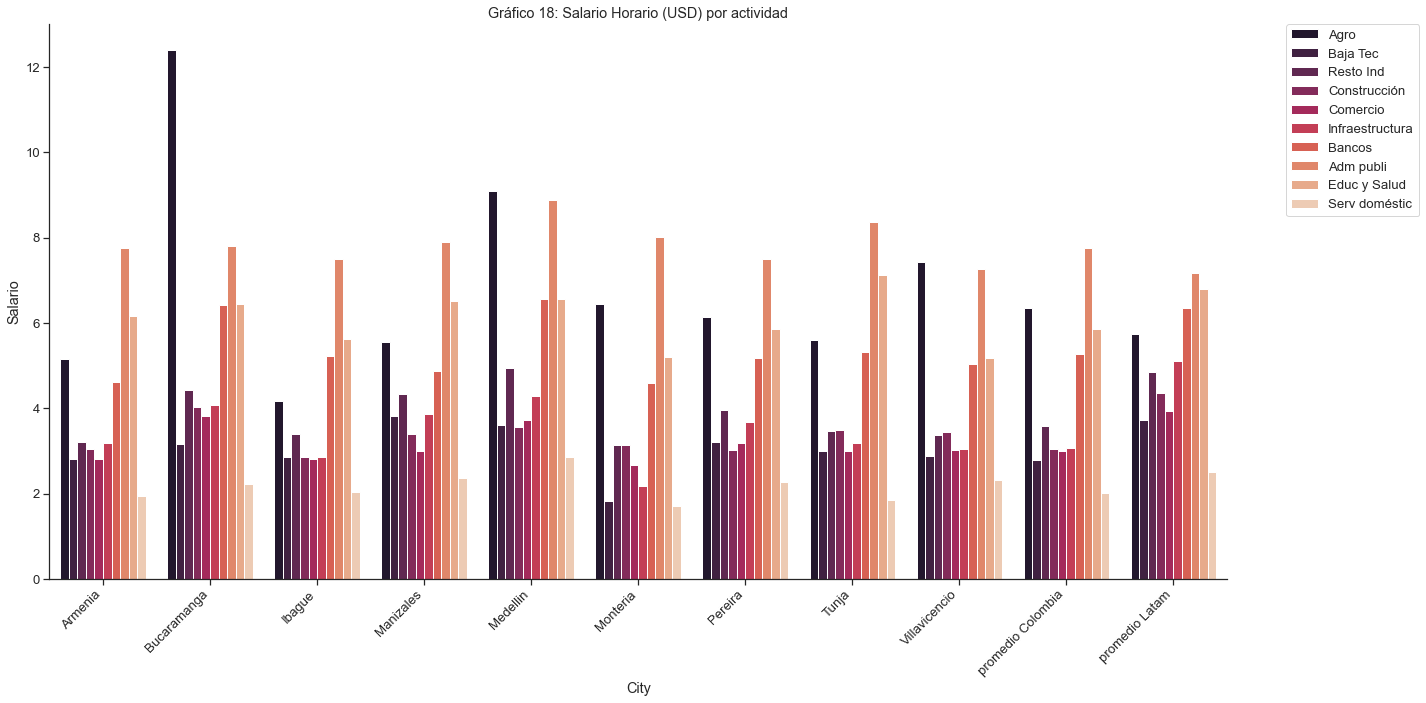

In [325]:
fig, ax = plt.subplots(1,1,figsize=(20,10)) #,constrained_layout=True

sns.barplot(x='City', y='Salario', hue='Actividad', data=plot , ax = ax, palette='rocket').set_title('Gráfico 18: Salario Horario (USD) por actividad')

ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

ax.set_xticklabels(plot['City'].unique().tolist() , rotation=45 , ha='right')

sns.set(font_scale=1.2)
sns.set_style("ticks")
sns.despine()

plt.savefig("C:/Users/Franco/Python/CAF/Entregables/Informes/manizales 2/informe/images/salarios.png",bbox_inches='tight')
plt.tight_layout()

Comparación salario real contra composición de salarios de sectores

In [151]:
wage = ta.iloc[:,2:12].join(ta.iloc[:,12:22])

In [152]:
wage['Salario Estimado'] = wage.apply(lambda row: row['wages_ s1'] * row['share_emp_s1'] + row['wages_ s2'] * row['share_emp_s2']
        + row['wages_ s3'] * row['share_emp_s3'] + row['wages_ s4'] * row['share_emp_s4']
        + row['wages_ s5'] * row['share_emp_s5'] + row['wages_ s6'] * row['share_emp_s6']
        + row['wages_ s7'] * row['share_emp_s7'] + row['wages_ s8'] * row['share_emp_s8']
        + row['wages_ s9'] * row['share_emp_s9'] + row['wages_ s10'] * row['share_emp_s10'],axis=1)

In [153]:
salarios_comp = wage.loc[:,'Salario Estimado'].to_frame().join(eph.loc[:,eph.columns[0]],how='inner').join(latlongs.loc[:,'geometry'].to_frame())

In [154]:
salarios_comp = salarios_comp.rename(columns={salarios_comp.columns[1]:'Salario Horario USD (PPP 2011)'})

In [155]:
salarios_comp['Brecha: Salario observado / Salario Estimado'] = (salarios_comp['Salario Horario USD (PPP 2011)'] / salarios_comp['Salario Estimado'])-1

In [156]:
salarios_comp_col = salarios_comp.loc['Colombia']

In [157]:
salarios_brecha = gpd.GeoDataFrame(salarios_comp_col , geometry= salarios_comp_col.geometry)

In [158]:
#(salarios_brecha[salarios_brecha.columns[1]] - salarios_brecha[salarios_brecha.columns[0]]) / salarios_brecha[salarios_brecha.columns[1]]

In [159]:
#salarios_brecha1 = salarios_brecha.drop(index=('Ibague'),axis=0)

<Figure size 432x288 with 0 Axes>

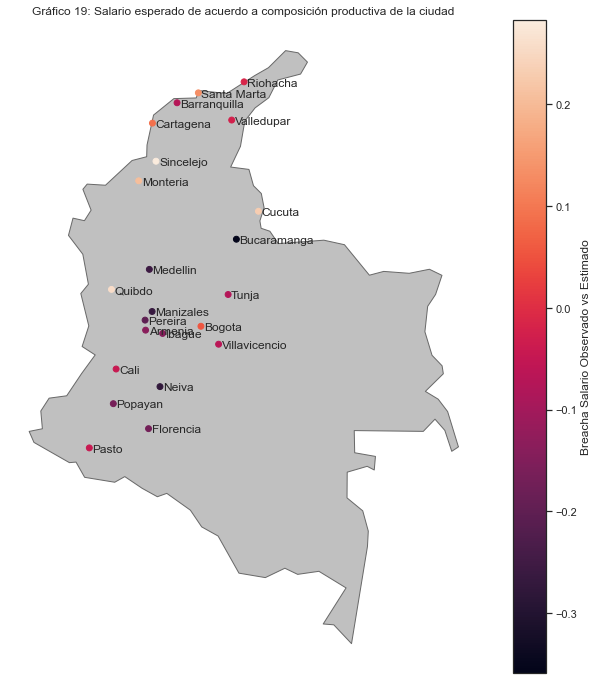

In [160]:
fig = plt.figure()
mpl.rcParams['figure.facecolor'] = 'white'

ax = world[world['name'].isin(['Colombia'])].plot(color='silver', figsize = (12,12), edgecolor='dimgrey') #,'Ecuador','Venezuela','Panama'
ax.axis('off')

bg_color = 'lightgrey'
ax.patch.set_facecolor(bg_color)

for x, y, label in zip(salarios_brecha.geometry.x, salarios_brecha.geometry.y, salarios_brecha.index):
    ax.annotate(label, xy=(x, y), xytext=(3, -4), textcoords="offset points" ,size=12)

salarios_brecha.plot(column='Brecha: Salario observado / Salario Estimado' , ax = ax, legend = True,  legend_kwds={'label':'Breacha Salario Observado vs Estimado'}, markersize = 35 , cmap='rocket').set_title('Gráfico 19: Salario esperado de acuerdo a composición productiva de la ciudad')
plt.savefig("C:/Users/Franco/Python/CAF/Entregables/Informes/manizales 2/informe/images/brecha_estvsreal.png" ,bbox_inches='tight')

In [161]:
salarios_brecha = salarios_brecha.reset_index()

In [162]:
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.005, point['y']+.05, str(point['val']))

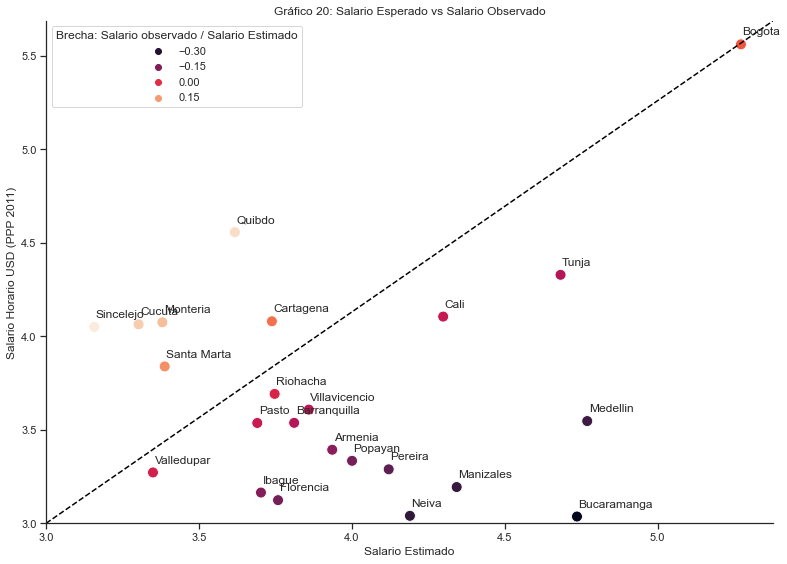

In [148]:
fig, ax = plt.subplots(figsize=(11,8))

sns.scatterplot(data=salarios_brecha, x="Salario Estimado", y="Salario Horario USD (PPP 2011)" , ax=ax  , hue='Brecha: Salario observado / Salario Estimado', s=120  , palette='rocket').set_title('Gráfico 20: Salario Esperado vs Salario Observado')

ax.plot([0, 1], [0, 1], transform=ax.transAxes , color='Black' , linestyle='--') 
#plt.legend(bbox_to_anchor=(0.95,0.95), loc="upper right")
#ax.get_legend().remove()

plt.tight_layout()
sns.set(font_scale=1.0)
sns.set_style("ticks")
sns.despine()

label_point( salarios_brecha["Salario Estimado"] , salarios_brecha["Salario Horario USD (PPP 2011)"] , salarios_brecha['City'] , plt.gca())

plt.xlim(3,)
plt.ylim(3,)

plt.savefig("C:/Users/Franco/Python/CAF/Entregables/Informes/manizales 2/informe/images/scat_esperado_observado.png",bbox_inches='tight')

In [163]:
sal_rat = salarios_brecha.set_index(['City']).join(merge.loc['Colombia'])

In [164]:
sal_rat['Sector Principal'] = sal_rat.loc[:,sal_rat.columns[-3:].tolist()].idxmax(axis=1)

In [165]:
sal_rat = sal_rat.reset_index()

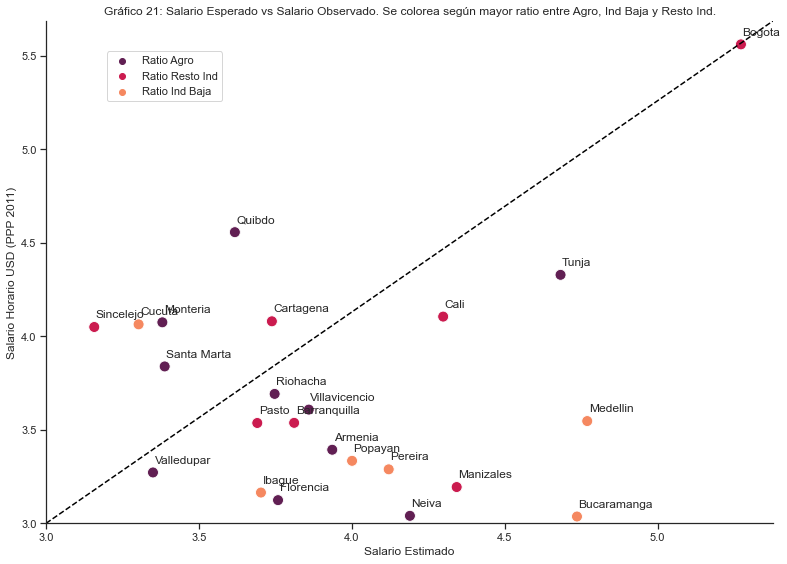

In [149]:
fig, ax = plt.subplots(figsize=(11,8))

sns.scatterplot(data=sal_rat, x="Salario Estimado", y="Salario Horario USD (PPP 2011)" , ax=ax  , hue='Sector Principal', s=120, palette='rocket').set_title('Gráfico 21: Salario Esperado vs Salario Observado. Se colorea según mayor ratio entre Agro, Ind Baja y Resto Ind.')

ax.plot([0, 1], [0, 1], transform=ax.transAxes , color='Black' , linestyle='--') 
plt.legend(bbox_to_anchor=(0.25,0.95), loc="upper right")
#ax.get_legend().remove()

plt.tight_layout()
sns.set(font_scale=1.0)
sns.set_style("ticks")
sns.despine()

label_point(sal_rat["Salario Estimado"] , salarios_brecha["Salario Horario USD (PPP 2011)"] , salarios_brecha['City'] , plt.gca())

plt.xlim(3,)
plt.ylim(3,)

plt.savefig("C:/Users/Franco/Python/CAF/Entregables/Informes/manizales 2/informe/images/scat_esperado_observado_2.png",bbox_inches='tight')

### Facilitación de Negocios

Doing BIZ II

In [169]:
construction = pd.read_excel('C:/Users/Franco/Python/CAF/files/Doing Business/construction.xlsx',index_col=[0,1]).loc[:,['Construction_Permits_Score','rank','dB_dwcp_procedures','dB_dwcp_time','dB_dwcp_cost','dB_dwcp_scoreindex']]

In [170]:
propiedad = pd.read_excel('C:/Users/Franco/Python/CAF/files/Doing Business/propiedad.xlsx',index_col=[0,1]).loc[:,['Registering_Property_Score','rank','dB_rp_procedures','dB_rp_time','dB_rp_cost','dB_rp_scroreindex']]

In [171]:
negocio = pd.read_excel('C:/Users/Franco/Python/CAF/files/Doing Business/negocio.xlsx',index_col=[0,1]).loc[:,['Starting_Business_Score','rank','dB_sb_procedures','dB_sb_time','dB_sb_cost']]

In [169]:
df = construction.loc[:,'dB_dwcp_time'].to_frame().join(propiedad.loc[:,'dB_rp_time']).join(negocio.loc[:,'dB_sb_time']).rename(columns={'dB_dwcp_time':'Días permiso de construcción','dB_rp_time':'Días registro de propiedad','dB_sb_time':'Días comienzo de negocio'})

In [170]:
medias = df.groupby('Country').mean().reset_index()
medias['City'] = ['Promedio Colombia','Promedio Mexico','Promedio Peru']
df = df.append(medias.set_index(['Country','City']))

In [171]:
ref_db = ['Manizales',
 'Pereira',
 'Medellín',
 'Armenia',
 'Villavicencio',
 'Montería',
 'Bucaramanga',
 'Ibagué',
 'Tunja',
 'Bogotá',
  'Promedio Colombia','Promedio Mexico','Promedio Peru']

In [172]:
df = df.loc[idx[:,ref_db],].reset_index()

In [173]:
dp = pd.melt(df,id_vars=['City'], value_vars=['Días permiso de construcción','Días registro de propiedad','Días comienzo de negocio'])

In [174]:
df1=dp[dp['variable']=='Días permiso de construcción'].sort_values('value').dropna()
df2=dp[dp['variable']=='Días registro de propiedad'].sort_values('value').dropna()
df3=dp[dp['variable']=='Días comienzo de negocio'].sort_values('value').dropna()

In [175]:
cl = [e for e in sns.color_palette('rocket',10)]
cl2 = [(int(t[0]*255), int(t[1]*255) , int(t[2]*255)) for t in cl]
colors = ['#%02x%02x%02x' % e for e in cl2]

In [176]:
color2 = [colors[2]]*13
color4 = [colors[4]]*13
color6 = [colors[0]]*13

In [177]:
color2[2]=colors[8]
color4[0]=colors[8]
color6[2]=colors[8]

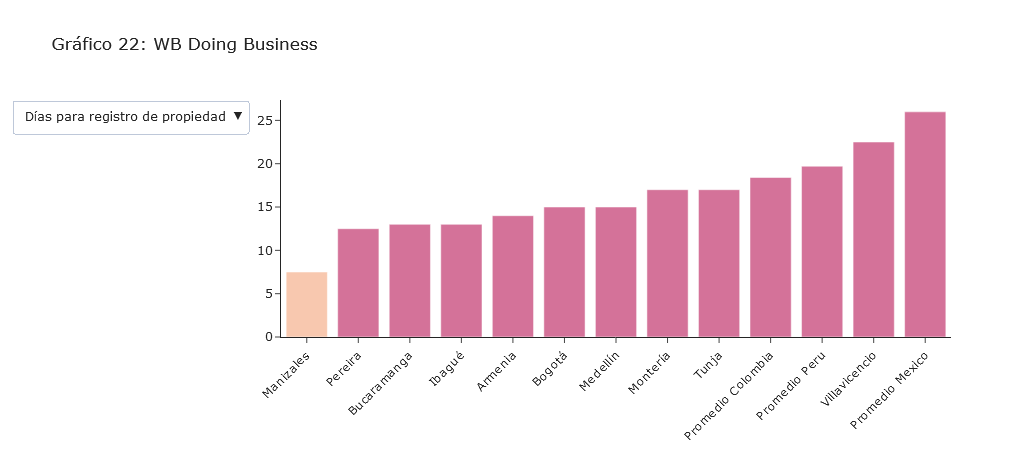

In [178]:
fig = go.Figure(data=[go.Bar( x=df1['City'], y=df1['value'] , marker={'color': color2})
                     ])

updatemenus = [
    {
        'buttons': [
            {
                'method': 'update',
                'label': 'Días para permiso de construcción',
                'args': [
                    {'y': [df1['value']],
                     'x': [df1['City']],
                     'marker':[{'color': color2}]
                    },  
                ]
            },
            {
                'method': 'update',
                'label': 'Días para registro de propiedad',
                'args': [
                    {'y': [df2['value']],
                     'x': [df2['City']],
                     'marker':[{'color': color4}]
                    },
                ]
            },
            {
                'method': 'update',
                'label': 'Días para comienzo de negocio',
                'args': [
                    {'y': [df3['value']],
                     'x': [df3['City']],
                     'marker':[{'color': color6}]
                    },
                ]
            }
        ],
        'direction': 'down',
        'showactive': True,
    }
]

fig.update_layout(template="simple_white" , updatemenus=updatemenus , title_text='Gráfico 22: WB Doing Business' , xaxis={'tickangle':-45})
fig.update_traces(marker_line_width=1.5, opacity=0.6)

fig.show()
fig.write_html("informe/images/db.html",full_html=False,include_plotlyjs='cdn')

Homicidios

In [150]:
homicidios = pd.read_excel(r'C:\Users\Franco\Python\CAF\files\Homicidios\homicidios_colombia(2016).xlsx').rename(columns={'Ciudad':'City'}).set_index('City').drop(columns=['Homicidios'])

In [151]:
homicidios = homicidios.reset_index().replace({'Ibagué':'Ibague','Cúcuta':'Cucuta'}).set_index('City')

In [152]:
homicidios = homicidios.rename(columns={homicidios.columns[1]:'Tasa (100.000 habitantes)'})

In [153]:
homicidios = homicidios.reset_index()
homicidios['City'] = homicidios['City'].str.lower().apply(lambda x: x.replace('á','a').replace('é','e').replace('í','i').replace('ó','o').replace('ú','u')).str.title()
homicidios = homicidios.set_index(['City'])

In [154]:
med = homicidios.mean().to_frame().T

In [155]:
med['City'] = 'promedio Colombia'

In [156]:
med = med.set_index('City')

In [157]:
homicidios = homicidios.append(med)

In [162]:
ref_com = ['Manizales',
 'Pereira',
 'Medellin',
 'Armenia',
 'Villavicencio',
 'Monteria',
 'Bucaramanga',
 'Ibague',
 'Tunja']

In [163]:
ref_hom = ref_com + ['Cali','Medellin','Bogota']

In [164]:
homicidios_ref = homicidios.loc[ref_hom,'Tasa (100.000 habitantes)'].to_frame().sort_values('Tasa (100.000 habitantes)')

Top de ciudades

In [165]:
homicidios2 = pd.read_excel(r'C:\Users\Franco\Python\CAF\files\Homicidios\top_homicidios(2016).xlsx')

In [166]:
homicidios2 = homicidios2.rename(columns={'Homicidios cada 100,000 hab,':'Tasa (100.000 habitantes)'})

homicidios2['City'] = homicidios2['City'].str.lower().apply(lambda x: x.replace('á','a').replace('é','e').replace('í','i').replace('ó','o').replace('ú','u')).str.title()
homicidios2['Country'] = homicidios2['Country'].str.lower().apply(lambda x: x.replace('á','a').replace('é','e').replace('í','i').replace('ó','o').replace('ú','u')).str.title()

In [167]:
homicidios2['Country'] = homicidios2.Country.str.replace(u'\xa0', u'')

In [168]:
homicidios2 = homicidios2.sort_values(['Country','City']).set_index(['Country','City'])

Promedios de paises (WB)

In [169]:
hom_wb = pd.read_excel(r'C:\Users\Franco\Python\CAF\files\Homicidios\wb.xls',header=3).rename(columns={'Country Name':'Country'})

In [170]:
prom = hom_wb.replace({'Country':{'Brazil':'Brasil'}}).set_index('Country').loc[['Colombia','Brasil','Ecuador','Argentina','Mexico','Chile','Peru'],['2015','2016','2017','2018']].reset_index()

In [171]:
prom['City'] = 'promedio ' + prom['Country'].astype(str)

In [172]:
prom = prom.set_index('City').rename(columns={'2016':'Tasa (100.000 habitantes)'})

In [173]:
hom = homicidios_ref.append(prom).loc[:,homicidios_ref.columns[0]].to_frame().sort_values('Tasa (100.000 habitantes)')

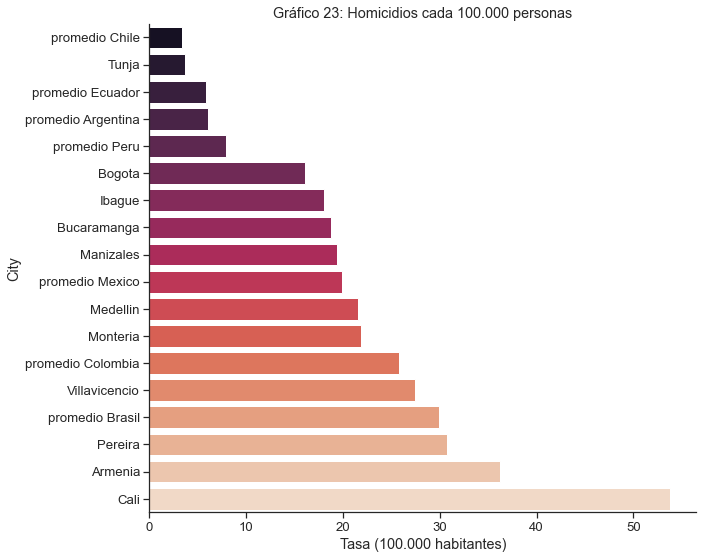

In [178]:
fig, ax = plt.subplots(figsize=(10,8)) #,constrained_layout=True
sns.barplot(x='Tasa (100.000 habitantes)', y=hom.index, data=hom , palette='rocket' , orient='h' ).set_title('Gráfico 23: Homicidios cada 100.000 personas')

#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.set(font_scale=1.2)
sns.set_style("ticks")
sns.despine()
#plt.ticklabel_format(style='plain', axis='x')
plt.savefig("C:/Users/Franco/Python/CAF/Entregables/Informes/manizales 2/informe/images/homicidios.png",bbox_inches='tight')
plt.tight_layout()

Properati

In [655]:
mylist = []

for file in os.listdir(r'C:\Users\Franco\Python\CAF\files\properati'):
    if file.endswith(".csv"):
        mylist += [file]

In [656]:
prope = pd.DataFrame()

for file in mylist:
    df = pd.read_csv(r'C:\Users\Franco\Python\CAF\files\properati\{}'.format(file))
    prope = prope.append(df)

In [657]:
prope = prope.drop(columns=['ad_type','rooms','bedrooms','bathrooms','title','description'])

In [658]:
prope = prope.loc[(prope['property_type'].isin(['Oficina','Local comercial','Depósito'])) & (prope['operation_type']=='Venta'),:]

In [154]:
#Diagnóstico
prope.groupby(['l1','currency']).count()

id  start_date  end_date  created_on    lat  \
l1             currency                                                   
Argentina      ARS         588         588       588         588    542   
               PEN           6           6         6           6      0   
               USD       26623       26623     26623       26623  24197   
Brasil         USD           3           3         3           3      3   
Colombia       COP       11437       11437     11437       11437   9530   
               USD         592         592       592         592      1   
Ecuador        USD        1198        1198      1198        1198   1061   
Estados Unidos USD           4           4         4           4      4   
Perú           PEN          56          56        56          56     53   
               USD        2081        2081      2081        2081   1883   
Uruguay        ARS           1           1         1           1      1   
               USD         841         841       841         841    798   

                           lon     l2     l3    l4    l5    l6  surface_total  \
l1             currency                                                         
Argentina      ARS         539    588    522    92     0     0            419   
               PEN           0      6      6     0     0     0              6   
               USD       24103  26623  26158  7616     5     0          15940   
Brasil         USD           3      3      2     2     0     0              0   
Colombia       COP        9530  11437  10431  6307  4964  2429           3050   
               USD           1    592      1     1     1     0              0   
Ecuador        USD        1061   1198   1183   999   811   122             37   
Estados Unidos USD           4      4      1     0     0     0              2   
Perú           PEN          53     56     55    47     9     0             37   
               USD        1883   2081   2004  1671   139     0           1447   
Uruguay        ARS           1      1      1     0     0     0              0   
               USD         798    841    554    31     0     0            161   

                         surface_covered  price  price_period  property_type  \
l1             currency                                                        
Argentina      ARS                   434    588           389            588   
               PEN                     5      6             6              6   
               USD                 16777  26623          9545          26623   
Brasil         USD                     1      3             1              3   
Colombia       COP                  4342  11437           169          11437   
               USD                     4    592             0            592   
Ecuador        USD                    11   1198            27           1198   
Estados Unidos USD                     1      4             4              4   
Perú           PEN                    38     56            39             56   
               USD                  1467   2081          1566           2081   
Uruguay        ARS                     0      1             0              1   
               USD                   365    841           193            841   

                         operation_type  
l1             currency                  
Argentina      ARS                  588  
               PEN                    6  
               USD                26623  
Brasil         USD                    3  
Colombia       COP                11437  
               USD                  592  
Ecuador        USD                 1198  
Estados Unidos USD                    4  
Perú           PEN                   56  
               USD                 2081  
Uruguay        ARS                    1  
               USD                  841

Armar una base con tipos de cambio por mes y mergearla para pasar las propiedades que no estan en USD (Colombia Solamente)

In [659]:
dxc = pd.read_excel(r'C:\Users\Franco\Python\CAF\files\properati\1.1.1.TCM_Serie histórica IQY.xlsx',header=7,usecols=[0,1],nrows=10608)

In [660]:
dxc['fecha'] = dxc['Fecha (dd/mm/aaaa)'].apply(lambda x: x.strftime('%Y-%m-%d'))

In [661]:
p = prope.merge(dxc.loc[:,['fecha','Tasa de cambio representativa del mercado (TRM)']],how='left',left_on='created_on',right_on='fecha',indicator=True)

In [662]:
p = p.loc[p['currency'].isin(['USD','COP'])]

In [663]:
p['price USD'] = np.where(p['currency']=='COP',p['price']/p['Tasa de cambio representativa del mercado (TRM)'],p['price'])

In [664]:
p['surface'] = np.where(p['surface_total'].notna(),p['surface_total'],p['surface_covered'])

In [665]:
p['price m2'] = p['price USD'] / p['surface']

In [666]:
p = p[p['price m2'].notna()]

In [667]:
p = p.rename(columns={'l1':'Country','l2':'Province','l3':'City','property_type':'Property Type'})[['created_on','Country','Province','City','currency','Property Type','price','price m2','surface','operation_type']]

In [668]:
p['City'] = np.where(p['Province']=='Montevideo','Montevideo',p['City'])

In [669]:
p['City'] = np.where(p['Province']=='Capital Federal','Buenos Aires',p['City'])

In [223]:
#p.loc[p['City']=='Cali'].groupby('Property Type').count()

Promedios Simples por ciudad

In [670]:
pm = p.groupby(['Country','City','Property Type']).mean()

In [225]:
medias = pm.groupby(['Country','Property Type']).mean()

Gráfico

In [226]:
ref_p = ['Armenia','Manizales','Medellín','Montería','Bucaramanga','Cartagena','Bahía Blanca','Mendoza','Lima','Guayaquil','Bogotá D.C','Ibagué','Quito','Rosario','Barranquila','Cali','Montevideo','Buenos Aires']

In [227]:
pplot = pm.loc[idx[:,ref_p],:]

In [228]:
col = medias.loc['Colombia']

In [229]:
col['City'] = 'promedio Colombia'

In [230]:
col = col.reset_index().set_index(['City','Property Type'])

df

In [231]:
df = pplot.droplevel(0).append(col).reset_index()

In [232]:
df1=df[df['Property Type']=='Depósito'].sort_values('price m2').dropna().reset_index()
df2=df[df['Property Type']=='Local comercial'].sort_values('price m2').dropna().reset_index()
df3=df[df['Property Type']=='Oficina'].sort_values('price m2').dropna().reset_index()

In [233]:
for e in [df1,df2,df3]:
    print(e.index[e['City']=='Manizales'])

Int64Index([], dtype='int64')
Int64Index([3], dtype='int64')
Int64Index([2], dtype='int64')


In [234]:
for e in [df1,df2,df3]:
    print(len(e))

13
17
17


In [235]:
cl = [e for e in sns.color_palette('rocket',20)]
cl2 = [(int(t[0]*255), int(t[1]*255) , int(t[2]*255)) for t in cl]
colors = ['#%02x%02x%02x' % e for e in cl2]

In [236]:
color2 = [colors[2]]*13
color4 = [colors[4]]*17
color6 = [colors[0]]*17

In [237]:
#color2[2]=colors[8]
color4[3]=colors[8]
color6[2]=colors[8]

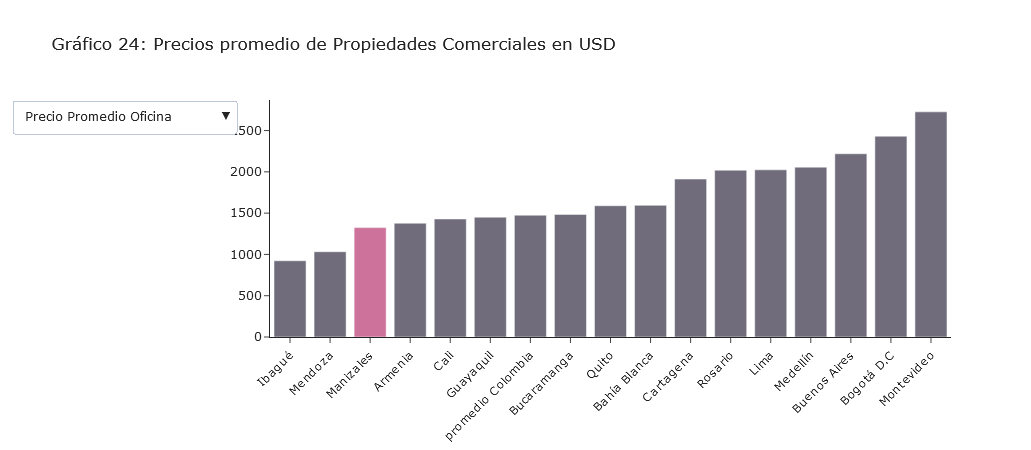

In [238]:
fig = go.Figure(data=[go.Bar( x=df1['City'], y=df1['price m2'] , marker={'color': color2})
                     ])

updatemenus = [
    {
        'buttons': [
            {
                'method': 'update',
                'label': 'Precio Promedio Depósito',
                'args': [
                    {'y': [df1['price m2']],
                     'x': [df1['City']],
                     'marker':[{'color': color2}]
                    },  
                ]
            },
            {
                'method': 'update',
                'label': 'Precio Promedio Local comercial',
                'args': [
                    {'y': [df2['price m2']],
                     'x': [df2['City']],
                     'marker':[{'color': color4}]
                    },
                ]
            },
            {
                'method': 'update',
                'label': 'Precio Promedio Oficina',
                'args': [
                    {'y': [df3['price m2']],
                     'x': [df3['City']],
                     'marker':[{'color': color6}]
                    },
                ]
            }
        ],
        'direction': 'down',
        'showactive': True,
    }
]

fig.update_layout(template="simple_white" , updatemenus=updatemenus , title_text='Gráfico 24: Precios promedio de Propiedades Comerciales en USD' , xaxis={'tickangle':-45})
fig.update_traces(marker_line_width=1.5, opacity=0.6)

fig.show()
fig.write_html("informe/images/prope.html",full_html=False,include_plotlyjs='cdn')

## Exporto las bases tablas que tengo limpias 

Tema acentos, usaremos esto: https://stackoverflow.com/questions/517923/what-is-the-best-way-to-remove-accents-normalize-in-a-python-unicode-string

In [208]:
import unidecode

In [ ]:
accented_string = u'Málaga'
# accented_string is of type 'unicode'
import unidecode
unaccented_string = unidecode.unidecode(accented_string)
# unaccented_string contains 'Malaga'and is of type 'str'

In [53]:
#mylist = ['Niteroi','Mérida','Gran Mendoza','Puebla-Tlaxcala','Salvador']

In [120]:
#mlab_latam.loc[('Brasil','Niteroi')]

Median Download  Median Upload  # Download   # Upload
Country City                                                          
Brasil  Niteroi            10.19           4.28  233,928.00 237,960.00

In [256]:
a = 'C:\\Users\\Franco\\Python\\CAF\\files\\clean\\'

In [258]:
a+'laboral.xlsx'

'C:\\Users\\Franco\\Python\\CAF\\files\\clean\\laboral.xlsx'

ta

In [298]:
ta = ta.reset_index()

In [299]:
ta['Ciudad'] = ta['City'].apply(lambda x: unidecode.unidecode(x))

In [300]:
ta['Pais'] = ta['Country'].apply(lambda x: unidecode.unidecode(x))

In [301]:
ta = ta.drop(columns=['Country','City']).rename(columns={'Ciudad':'City','Pais':'Country'}).set_index(['Country','City'])

In [302]:
ta = ta.iloc[:,2:]

In [310]:
ta['Salario Estimado'] = ta.apply(lambda row: row['wages_ s1'] * row['share_emp_s1'] + row['wages_ s2'] * row['share_emp_s2']
        + row['wages_ s3'] * row['share_emp_s3'] + row['wages_ s4'] * row['share_emp_s4']
        + row['wages_ s5'] * row['share_emp_s5'] + row['wages_ s6'] * row['share_emp_s6']
        + row['wages_ s7'] * row['share_emp_s7'] + row['wages_ s8'] * row['share_emp_s8']
        + row['wages_ s9'] * row['share_emp_s9'] + row['wages_ s10'] * row['share_emp_s10'],axis=1)

array([<AxesSubplot:title={'center':'Argentina'}>,
       <AxesSubplot:title={'center':'Bolivia'}>,
       <AxesSubplot:title={'center':'Brasil'}>,
       <AxesSubplot:title={'center':'Chile'}>,
       <AxesSubplot:title={'center':'Colombia'}>,
       <AxesSubplot:title={'center':'Costa Rica'}>,
       <AxesSubplot:title={'center':'Ecuador'}>,
       <AxesSubplot:title={'center':'Mexico'}>,
       <AxesSubplot:title={'center':'Panama'}>,
       <AxesSubplot:title={'center':'Paraguay'}>,
       <AxesSubplot:title={'center':'Peru'}>,
       <AxesSubplot:title={'center':'Uruguay'}>], dtype=object)

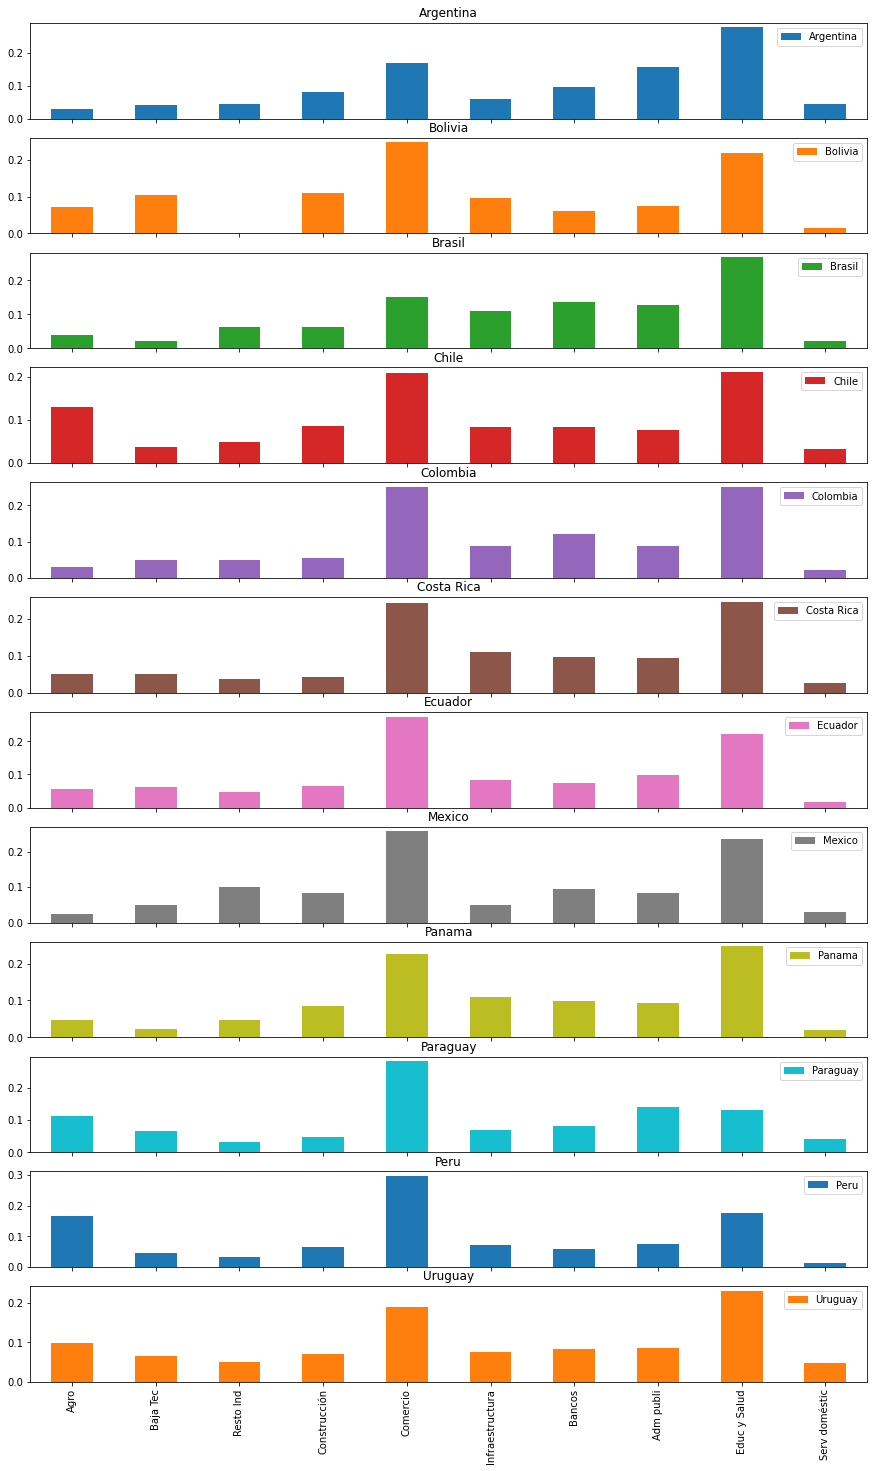

In [202]:
#ta.iloc[:,33:43].groupby(['Country']).mean().T.plot(kind='bar',subplots=True,figsize=(15,25))

In [312]:
ta.to_excel(a+'sectores.xlsx')

eph

In [313]:
eph = eph.reset_index()

In [314]:
eph['Ciudad'] = eph['City'].apply(lambda x: unidecode.unidecode(x))

In [315]:
eph['Pais'] = eph['Country'].apply(lambda x: unidecode.unidecode(x))

In [316]:
eph = eph.drop(columns=['Country','City']).rename(columns={'Ciudad':'City','Pais':'Country'}).set_index(['Country','City'])

In [317]:
eph.to_excel(a+'laboral.xlsx')

acceso

In [141]:
shares_cutoff.shape

(423, 11)

In [318]:
shares_cutoff = shares_cutoff.reset_index()

In [319]:
shares_cutoff['Ciudad'] = shares_cutoff['City'].apply(lambda x: unidecode.unidecode(x))

In [320]:
shares_cutoff['Pais'] = shares_cutoff['Country'].apply(lambda x: unidecode.unidecode(x))

In [321]:
shares_cutoff = shares_cutoff.drop(columns=['Country','City']).rename(columns={'Ciudad':'City','Pais':'Country'}).set_index(['Country','City'])

In [322]:
shares_cutoff.to_excel(a+'accesom.xlsx')

distancias y geom

In [145]:
distances.shape

(25592, 12)

In [325]:
distances['Ciudad A'] = distances['City A'].apply(lambda x: unidecode.unidecode(x))

In [326]:
distances['Ciudad B'] = distances['City B'].apply(lambda x: unidecode.unidecode(x))

In [327]:
distances['Pais'] = distances['Country'].apply(lambda x: unidecode.unidecode(x))

In [328]:
distances = distances.drop(columns=['Country','City A','City B']).rename(columns={'Ciudad A':'City','Pais':'Country','Ciudad B':'City B'}).set_index(['Country','City'])

In [330]:
distances.to_excel(a+'distances.xlsx')

poblaciones

In [381]:
cwpops.shape

(422, 11)

In [382]:
cwpops = cwpops.reset_index()

In [383]:
cwpops['Ciudad'] = cwpops['City'].apply(lambda x: unidecode.unidecode(x))

In [384]:
cwpops['Pais'] = cwpops['Country'].apply(lambda x: unidecode.unidecode(x))

In [385]:
cwpops = cwpops.drop(columns=['Country','City']).rename(columns={'Ciudad':'City','Pais':'Country'})#.set_index(['Country','City'])

In [386]:
cwpops['City2'] = cwpops['City'].str.split('-').str[0].str.replace('Gran ','').str.replace('Panama ','')

In [495]:
cwpops.set_index(['Country','City']).to_excel(a+'cwpops.xlsx')

Internet

mlab_clean tiene los nombres correctos, mlab_latam hace falta revisar

In [430]:
mlab = mlab_latam.reset_index()

In [431]:
mlab['Ciudad'] = mlab['City'].apply(lambda x: unidecode.unidecode(x))

In [432]:
mlab['Pais'] = mlab['Country'].apply(lambda x: unidecode.unidecode(x))

In [433]:
mlab = mlab.drop(columns=['Country','City']).rename(columns={'Ciudad':'City','Pais':'Country'}).set_index(['Country','City'])

In [523]:
mlab.set_index(['Country','City']).to_excel(a+'mlab.xlsx')

Uso cwpops['City2'] para hacer el merge y así limpiar bien la base

In [466]:
cw = cwpops

In [469]:
mlab = mlab.reset_index()

In [496]:
mlab_inner = mlab.merge(cw,how='inner',left_on=['Country','City'],right_on=['Country','City2'],indicator=True)

In [501]:
mlabi = mlab_inner.rename(columns={'City_y':'City','City_x':'City Original'}).set_index(['Country','City'])

In [504]:
mlabi = mlabi.drop(columns=mlabi.columns[5:])

In [506]:
mlabi.to_excel(a+'mlabi.xlsx')

porperati: revisar tema de acentos en nobmres y demás

In [187]:
pm.groupby(['Country','Property Type']).count()

price  price m2  surface
Country   Property Type                            
Argentina Depósito            86        86       86
          Local comercial    194       194      194
          Oficina             80        80       80
Colombia  Depósito            28        28       28
          Local comercial    102       102      102
          Oficina             34        34       34
Ecuador   Depósito             4         4        4
          Local comercial      3         3        3
          Oficina              5         5        5
Perú      Depósito            10        10       10
          Local comercial     32        32       32
          Oficina             11        11       11
Uruguay   Depósito             3         3        3
          Local comercial     12        12       12
          Oficina              2         2        2

In [671]:
pm = pm.reset_index()

In [672]:
pm['Ciudad'] = pm['City'].apply(lambda x: unidecode.unidecode(x))

In [673]:
pm['Pais'] = pm['Country'].apply(lambda x: unidecode.unidecode(x))

In [674]:
pm = pm.drop(columns=['Country','City']).rename(columns={'Ciudad':'City','Pais':'Country'})

In [675]:
pm.set_index(['Country','City']).to_excel(a+'properati.xlsx')

In [514]:
pm_inner = pm.merge(cw,how='inner',left_on=['Country','City'],right_on=['Country','City2'],indicator=True)

In [516]:
pm_right = pm.merge(cw,how='right',left_on=['Country','City'],right_on=['Country','City2'],indicator=True)

In [528]:
pmi = pm_inner.rename(columns={'City_y':'City','City_x':'City Original'}).set_index(['Country','City'])

In [533]:
pmi = pmi.drop(columns=pmi.columns[5:])

In [534]:
pmi.to_excel(a+'properati_i.xlsx')

Doing Biz

In [571]:
dbiz = construction.join(propiedad,rsuffix=' rp',lsuffix=' cp').join(negocio,rsuffix=' sb').rename(columns={'dB_dwcp_time':'Días permiso de construcción','dB_rp_time':'Días registro de propiedad','dB_sb_time':'Días comienzo de negocio'})

In [572]:
dbiz = dbiz.reset_index()

In [573]:
dbiz['Ciudad'] = dbiz['City'].apply(lambda x: unidecode.unidecode(x))

In [574]:
dbiz['Pais'] = dbiz['Country'].apply(lambda x: unidecode.unidecode(x))

In [575]:
dbiz = dbiz.drop(columns=['Country','City']).rename(columns={'Ciudad':'City','Pais':'Country'})

In [576]:
dbiz.set_index(['Country','City']).to_excel(a+'dbiz.xlsx')

Volar paréntesis

In [611]:
dbiz['City2'] = dbiz['City'].str.split(' \(').str[0]

In [645]:
dbiz = dbiz.replace({'City2':dict(zip(dbiz_left.loc[dbiz_left['_merge']=='left_only','City_x'].tolist()[9:11]+dbiz_left.loc[dbiz_left['_merge']=='left_only','City_x'].tolist()[12:14]+[dbiz_left.loc[dbiz_left['_merge']=='left_only','City_x'].tolist()[15]]+dbiz_left.loc[dbiz_left['_merge']=='left_only','City_x'].tolist()[17:],['Valle de Mexico','Juarez','Oaxaca','Pachuca','Arequipa ','Cuzco','Callao y Lima','San Martin/Tarapoto']))})

In [646]:
dbiz_inner = dbiz.merge(cw,how='inner',left_on=['Country','City2'],right_on=['Country','City2'],indicator=True)

In [647]:
dbiz_left = dbiz.merge(cw,how='left',left_on=['Country','City2'],right_on=['Country','City2'],indicator=True)

In [653]:
dbizi = dbiz_inner.drop(columns=['_merge','City2','masalarial', 'avg_wg', 'index1', 'estimated_hourly_wage_US',
       'nearest_loc', 'parsed_duration', 'beam_pop', 'proy2019', 'censo2010',
       'pops', 'estimated_citywage']).rename(columns={'City_y':'City','City_x':'City old'}).set_index(['Country','City'])

In [654]:
dbizi.to_excel(a+'dbizi.xlsx')

ES

In [779]:
mylist = ta.reset_index().Country.unique().tolist()+['Costa Rica']

In [780]:
es = pd.read_excel('c:/Users/Franco/Python/CAF/files/ES.xlsx' , sheet_name='Biggest Obstacle')

In [781]:
es_latam = es[es['Economy'].isin(mylist)]

In [782]:
es_city = es_latam[es_latam['Subgroup']=='Location']

In [783]:
es_city = es_city.rename(columns={'Economy':'Country','Subgroup Level':'City'}).set_index(['Country','City'])

In [784]:
es_city['Year'] = es_city['Year'].astype('int')

In [785]:
keep = es_city.groupby('Country')['Year'].max().reset_index()

In [786]:
es_city = es_city.reset_index().merge(keep,how='inner',on=['Country','Year']).drop(columns=['Subgroup','Top Subgroup Level','Average/SE/N'])

In [787]:
es_city[es_city.columns[3:]] = es_city[es_city.columns[3:]].astype('float')

Tema de Nombre de Pais/Ciudad

In [788]:
es_city['Ciudad'] = es_city['City'].apply(lambda x: unidecode.unidecode(x))

In [789]:
es_city['Pais'] = es_city['Country'].apply(lambda x: unidecode.unidecode(x))

In [790]:
es_city = es_city.drop(columns=['Country','City']).rename(columns={'Ciudad':'City','Pais':'Country'})

In [793]:
es_left = es_city.merge(cw,how='left',left_on=['Country','City'],right_on=['Country','City2'],indicator=True)

In [794]:
mylist = es_left.loc[(es_left['_merge']=='left_only'),'City_x'].tolist()

In [795]:
mydict=dict(zip(mylist[:4]+mylist[5:7]+mylist[8:9]+[mylist[16]]+[mylist[18]]+mylist[20:],['Ciudad de Buenos Aires','Cercado/Cochabamba','Pedro Domingo Murillo/La Paz y el Alto','Andres Ibanez/Santa Cruz de la Sierra','Region Metropolitana de Santiago','Gran Valpariso','Gran Area Metropolitana','Valle de Mexico','Ciudad de Panama','Arequipa ','Callao y Lima']))

In [796]:
es_city = es_city.replace({'City':mydict})

In [797]:
es_city = es_city.merge(cw,how='inner',left_on=['Country','City'],right_on=['Country','City2'],indicator=True)

In [803]:
es_city = es_city.rename(columns={'City_x':'City old','City_y':'City'}).drop(columns=['masalarial', 'avg_wg', 'index1',
       'estimated_hourly_wage_US', 'nearest_loc', 'parsed_duration',
       'beam_pop', 'proy2019', 'censo2010', 'pops', 'estimated_citywage']).set_index(['Country','City'])

In [804]:
es_city.to_excel(a+'es.xlsx')

Airports

In [839]:
airports = pd.read_csv('C:/Users/Franco/Python/CAF/files/airports/airports.csv')

In [846]:
airports = airports.drop(columns='Dist')

In [842]:
airports['geometry'] = airports['geometry'].apply(wkt.loads)

In [843]:
air = gpd.GeoDataFrame(airports,geometry='geometry',crs={'init':'epsg:4326'})

In [856]:
air.to_crs(epsg=3310,inplace=True)

In [905]:
cities = distances.reset_index().rename(columns={'Point A':'Point'}).loc[:,['Country','City','Point']].drop_duplicates()

In [906]:
cities = cities.rename(columns={'Point':'geometry'})

In [907]:
cities = cities.dropna(subset=['geometry'])

In [928]:
cities['lat'] = cities['geometry'].str.split(',').apply(lambda x: x[0])

In [929]:
cities['long'] = cities['geometry'].str.split(',').apply(lambda x: x[1])

In [933]:
cities['lat'] = cities['lat'].astype('float')
cities['long'] = cities['long'].astype('float')

In [936]:
cities = gpd.GeoDataFrame(cities,geometry=gpd.points_from_xy(cities.long, cities.lat),crs={'init':'epsg:4326'})

In [937]:
cities.to_crs(epsg=3310,inplace=True)

In [947]:
from shapely.ops import nearest_points

In [949]:
pts = air.geometry.unary_union

In [980]:
cities['airp_cercano'] = cities['geometry'].apply(lambda x: nearest_points(x, pts)[1])

In [963]:
#def near(point, p=pts):
#     # find the nearest point and return the corresponding Place value
#    nearest = nearest_points(point, p)[0]
#    #return air[nearest].Place.get_values()[0]
#    return nearest

In [985]:
nearest_points(cities['geometry'][0],pts)

tuple

In [986]:
cities['Dist_air'] = cities['geometry'].distance(cities['airp_cercano'])

In [993]:
cities.to_excel(a+'geom_air.xlsx')

In [994]:
cities.loc[cities['City']=='Manizales']

Country       City                          geometry  lat   long  \
15333  Colombia  Manizales  POINT (5347394.381 -2232827.262) 5.06 -75.51   

                           airp_cercano  Dist_air  
15333  POINT (5353540.737 -2233280.758)  6,163.06